# Efficiency optimization




给定数据结构：
```
merged_data_for_analysis
│
├─ net_npv_usd
│
├─ predicted_prob
│
└─ Expectation_net_benefit
```

目标函数构造：

给定某个排列$\pi$
$$\pi:\{1,\dots,n\}\rightarrow \{1,\dots,n\}$$

我们引入对$[0,1]$实施优先分位数的偏好核函数$f(u)$：
我们在这里使用递减的偏好核函数，并且把偏好核函数离散为每个位置的权重
 将基线核函数 \( f(u) \) 离散化为每个位置的权重：

 $$
 w_k = \int_{(k-1)/n}^{k/n} f(u)\,du \approx f\left(\frac{k-0.5}{n}\right) \cdot \frac{1}{n},\quad k=1, \ldots, n
 $$

效率的一般形式函数被定义为以下形式，本质上这个函数的目标是构造出一个可供pymoo搜索的权重空间，以下给出A维度下的目标函数构造  

$$
 E_{A}(\pi) = \int_{0}^{1} A_{\pi(\lfloor un \rfloor)}\, w(u)\, du.
$$
在这个函数中，排序由优化搜索；
核函数由效率形式推导（例如递减核 1-u → 鼓励把大值排到前面）


要优化的目标：
- 单目标：$maxE_{A}(\pi)$, $maxE_{B}(\pi)$,$maxE_{C}(\pi)$
- 双目标：$(maxE_{A}(\pi),maxE_{B}(\pi))$,$(maxE_{B}(\pi),maxE_{C}(\pi))$,$(maxE_{A}(\pi),maxE_{C}(\pi))$
- 三目标：$(maxE_{A}(\pi),maxE_{B}(\pi),maxE_{C}(\pi))$



可视化要求：

给出排序前沿的frontier的图；
记录这些排序，并且给出该排序下，3个维度的累积效益曲线；
```python

def create_cross_target_analysis_individual(merged_data_for_plot):
    """
    创建交叉目标分析图，逐个输出三个子图，参照plot_single_variable_nature_style的尺寸设计
    直接使用merged_data_for_plot作为数据源
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch, FancyArrowPatch
    
    # 设置字体参数，参考plot_single_variable_nature_style
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # 定义四个变量
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Feasibility', 'USD'),
        ('ccd_optimized', 'Coordination Index', 'Index')
    ]
    plot_variables = variables[:3]

    # 修改颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色
    coordination_color = '#3c6b99'  # 蓝灰

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color,
        'ccd_optimized': coordination_color
    }

    # 映射变量名到线型
    variable_linestyles = {
        'predicted_prob': ':',        # 点线
        'Expectation_net_benefit': '--',  # 虚线
        'avg_npv': '-',               # 实线
        'ccd_optimized': '-.'         # 点划线
    }

    # 面板标签
    panel_labels = ['', '', '']

    # ==================== 数据预处理 ====================
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    
    # 检查必要的列是否存在
    required_cols = ['lat', 'area_m2'] + [var[0] for var in variables]
    missing_cols = [col for col in required_cols if col not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 计算总面积
    area_values = merged_data_for_plot['area_m2'].values / 10000  # 转换为公顷
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # 逐个生成图片
    for idx, (variable_name, variable_label, unit) in enumerate(plot_variables):
        # 参照plot_single_variable_nature_style的figsize，但调整为适合折线图的尺寸
        # fig, ax = plt.subplots(1, 1, figsize=(1.97, 1.6))  # 50mm width ≈ 1.97 inch
        # ax.set_title(variable_label, fontsize=7, fontweight='bold', ha='center', va='top', pad=12)
        fig, ax = plt.subplots(1, 1, figsize=(52/25.4, 36/25.4))  # 60mm x 40mm

        # 获取当前变量的数据
        benefit_density_values = merged_data_for_plot[variable_name].values
        if variable_name == 'Expectation_net_benefit':
            benefit_density_values = benefit_density_values / 0.27 

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values * area_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # 当前变量曲线（目标曲线）
        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        # 其他两个变量的曲线（交叉曲线）
        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data_for_plot[other_var_name].values
                if other_var_name == 'Expectation_net_benefit':
                    other_density_values = other_density_values / 0.27 
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values * area_values
                else:
                    other_total_values = other_density_values * area_values
                
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'linestyle': variable_linestyles[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits,
                    'var_name': other_var_name
                })

        # 绘制目标曲线（当前变量）
        target_color_current = variable_colors[variable_name]
        target_linestyle_current = variable_linestyles[variable_name]
        ax.plot(target_cumulative_percentage, target_cumulative_benefits,
                 color=target_color_current, linewidth=1.5, alpha=0.9, 
                 linestyle=target_linestyle_current, zorder=8,
                 label=f'{variable_label.split(" ")[0]}')

        # 绘制交叉曲线（其他两个变量）
        for curve in cross_curves_data:
            ax.plot(curve['percentage'], curve['benefits'],
                     color=curve['color'], linewidth=1.5, alpha=0.9, 
                     linestyle=curve['linestyle'], zorder=6,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和阴影
        if variable_name == 'avg_npv':
            ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=7,
                      label='Break-even Line')
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            if np.any(economic_negative_mask):
                first_negative_idx = np.where(economic_negative_mask)[0][0]
                if first_negative_idx > 0:
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        ax.axvspan(intersection_x, 100, color='gray', alpha=0.3, zorder=1, 
                                   label='Negative Region')

        # X轴标签
        ax.text(0.5, -0.13, 'Priority order', transform=ax.transAxes, ha='center', va='top',
                fontsize=6, fontweight='bold')

        # 设置X轴刻度
        key_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        xtick_positions = [p for p in key_percentages if p >= 10]
        xtick_labels = [f'{p}' for p in xtick_positions]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=6)
        ax.set_xlim(0, 105)

        # 设置Y轴范围和格式化，并减少y轴刻度数量
        all_curves_min = target_cumulative_benefits.min()
        all_curves_max = target_cumulative_benefits.max()
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        
        if variable_name == 'predicted_prob':
            # Environmental: 除以1e6，保留1位小数，显示1e6
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.set_ylabel('cumulative score (Unitless, $\\times 10^6$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'Expectation_net_benefit':
            # Emission: 除以1e9，保留1位小数，显示1e9
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('cumulative mitigation (Gt CO$_2$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'avg_npv':
            # Economic: 除以1e9，保留1位小数，显示1e9
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            y_min = all_curves_min - y_range * 0.1
            y_max = all_curves_max + y_range * 0.1
            ax.set_ylim(y_min, y_max*1.05)
            ax.set_ylabel('cumulative revenue (Billion USD)', fontsize=6, fontweight='bold', labelpad=1.2)

            # 生成yticks，并确保0会被标注出来
            yticks = np.linspace(y_min, y_max, 5)
            # 判断0是否已经在yticks里，如果不在，则插入
            if not np.isclose(yticks, 0).any() and (0 > yticks.min()) and (0 < yticks.max()):
                yticks = np.sort(np.append(yticks, 0))
            ax.set_yticks(yticks)
            
            def billion_formatter(x, pos):
                if np.isclose(x, 0):
                    return '0'
                return f'{x/1e9:.1f}'
            ax.yaxis.set_major_formatter(FuncFormatter(billion_formatter))

        # 10%分位线
        ax.axvline(10, color='#B71C1C', linestyle=':', linewidth=1.2, alpha=0.8, zorder=7)
        ax.text(0.10, 1.02, '', transform=ax.transAxes, ha='center', va='bottom', fontsize=5, color='#B71C1C')

        # 轴向箭头
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        arrow_x = FancyArrowPatch(
            posA=(x_lim[1], 0),
            posB=(x_lim[1] + (x_lim[1] - x_lim[0]) * 0.06, 0),
            transform=ax.get_xaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_x.set_clip_on(False)
        ax.add_patch(arrow_x)

        arrow_y = FancyArrowPatch(
            posA=(0, y_lim[1]),
            posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) * 0.05),
            transform=ax.get_yaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_y.set_clip_on(False)
        ax.add_patch(arrow_y)

        # 网格和样式设置
        # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)  # 不需要网格，已注释
        ax.set_axisbelow(True)
        
        # 坐标轴样式设置
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
        # 设置坐标轴线的颜色和粗细
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')

        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 布局调整 - 参照plot_single_variable_nature_style的坐标轴位置
        ax.set_position([0.2, 0.15, 0.75, 0.75])  
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/cross_target_{variable_name}_individual.png"
        filename_pdf = f"figure/US_figure/cross_target_{variable_name}_individual.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
        
        plt.show()
        plt.close(fig)
        
        print(f"已生成 {variable_name} 的交叉目标分析图")

    print("所有交叉目标分析图生成完成！")
    return fig, ax

# 执行函数
fig, ax = create_cross_target_analysis_individual(merged_data_for_plot)
```


请进一步修改函数：

对于单目标A,B,C，可以直接用简单排序[::-1]作为baseline以及可以对比启发式算法的一部分
需要你做两个小修改
1、在single objective层面构建开关，控制是否开启算法

如果只是为了得到单目标 π*，直接设 use_ga=False 就完事了，你不需要跑任何 GA/NSGA2。
```python
def run_single_objective_optimization(..., use_ga=False):
    ...

    # 先计算简单排序
    values = data_dict[f'{objective}_values']
    simple_sort = np.argsort(values)[::-1]
    E_simple = compute_efficiency(simple_sort, values, data_dict['weights'])

    if not use_ga:
        print(f"直接使用简单排序，E_{objective} = {E_simple:.6e}")
        return {
            'problem': None,
            'result': None,
            'best_permutation': simple_sort,
            'best_efficiency': E_simple,
            'E_A': compute_efficiency(simple_sort, data_dict['A_values'], data_dict['weights']),
            'E_B': compute_efficiency(simple_sort, data_dict['B_values'], data_dict['weights']),
            'E_C': compute_efficiency(simple_sort, data_dict['C_values'], data_dict['weights']),
            'objective': objective
        }

```

2、如果use_ga=True，那就把「简单排序解」塞进初始种群里，当成一个精英个体（相当于一开始就从解析最优解出发），替换当前的PermutationRandomSampling方式。并且在run_single_objective_optimization写入参数

```python
from pymoo.core.sampling import Sampling

class SeededPermutationSampling(Sampling):
    def __init__(self, seed_perm):
        super().__init__()
        self.seed_perm = np.asarray(seed_perm, dtype=int)

    def _do(self, problem, n_samples, **kwargs):
        n = problem.n_var
        X = np.zeros((n_samples, n), dtype=int)

        # 第一个个体用简单排序
        X[0] = self.seed_perm

        # 其他个体随机排列
        for i in range(1, n_samples):
            X[i] = np.random.permutation(n)

        return X
def run_single_objective_optimization()

    # simple_sort = 解析最优解
    values = data_dict[f'{objective}_values']
    simple_sort = np.argsort(values)[::-1]

    # 使用 seeded sampling
    sampling = SeededPermutationSampling(simple_sort)

    crossover = OrderCrossover(prob=0.9)
    mutation = InversionMutation(prob=0.3)

    algorithm = GA(
        pop_size=pop_size,
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        eliminate_duplicates=True
)


```

3、增加逻辑判断并输出合理的打印信息，表明搜索的各个方案是小于简单排序的。

4、在双目标、三目标优化层面。本质上他们可以转化为单目标而不用直接搜索，因为权重与排序的顺序是共享的。
$$
E_{\lambda}(\pi) = \lambda E_A(\pi) + (1 - \lambda) E_B(\pi)
$$
$$
E_{\lambda}(\pi) = \sum_k \left( \lambda A_k + (1 - \lambda) B_k \right) w_k
$$

因此本质上可以转化为这个目标为单目标，利用解析法生成K条候选曲线点
把这些点作为你的 “population” 输入 pymoo
用 pymoo 的 NonDominatedSorting 得到 Pareto front

5、考虑到不同的数据量纲问题，在搜索过程中需要先进行标准化




1、在经过特定权重偏好的排序之后，我所得到的本质上是特定偏好下最优排序。现在我有一个函数，它定义了随机观测下（假定0，1分位数优先区内随机观测），被认为是政策表现效率

$$
\mathbb{E}\left[f(U)\right] = \int_0^1 f(u) \, du, \quad U \sim \mathrm{Uniform}(0,1)
$$
表现效率的代码参考为

```python

def calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95):
    """
    计算各个维度优先区方案的平均效率、变异系数和置信区间
    增加基于 ccd_optimized 的排序统计
    优化：统一列名，消除NaN
    """
    
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score', 'Environmental'),
        ('Expectation_net_benefit', 'Emission Mitigation', 't', 'Emission'),
        ('avg_npv', 'Economic Feasibility', 'USD', 'Economic'),
        ('ccd_optimized', 'Coordination Index', 'CCD', 'Coordination')
    ]
    
    area_values = merged_data_for_plot['area_m2'].values / 10000  # ha
    total_area = area_values.sum()
    
    def percentage_to_01(pct): 
        return pct / 100.0
    
    def calculate_integral(x, y):
        if len(x) < 2: 
            return 0.0
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        return np.trapz(y, x)
    
    all_integrals = {}
    
    for variable_name, variable_label, unit, short_name in variables:
        dens = merged_data_for_plot[variable_name].values.astype(float)
        if variable_name == 'Expectation_net_benefit':
            dens = dens / 0.27
        total_vals = dens * area_values
        integrals = {}
        idx_sort = np.argsort(total_vals)[::-1]
        cum_ben = np.cumsum(total_vals[idx_sort])
        cum_pct = np.arange(1, len(cum_ben) + 1) / len(cum_ben) * 100
        cum_ben = np.concatenate([[0], cum_ben])
        cum_pct = np.concatenate([[0], cum_pct])
        x01 = percentage_to_01(cum_pct)
        integral_main = calculate_integral(x01, cum_ben) / total_area
        integrals[short_name] = integral_main
        for other_var_name, other_var_label, _, other_short_name in variables:
            if other_var_name == variable_name:
                continue
            other_dens = merged_data_for_plot[other_var_name].values.astype(float)
            if other_var_name == 'Expectation_net_benefit':
                other_dens = other_dens / 0.27
            other_total = other_dens * area_values
            idx_cross = np.argsort(other_total)[::-1]
            cross_cum_ben = np.cumsum(total_vals[idx_cross])
            cross_cum_pct = np.arange(1, len(cross_cum_ben) + 1) / len(cross_cum_ben) * 100
            cross_cum_ben = np.concatenate([[0], cross_cum_ben])
            cross_cum_pct = np.concatenate([[0], cross_cum_pct])
            x01 = percentage_to_01(cross_cum_pct)
            integral_cross = calculate_integral(x01, cross_cum_ben) / total_area
            integrals[other_short_name] = integral_cross
        all_integrals[variable_name] = integrals
    
    sort_methods = ['Environmental', 'Emission', 'Economic', 'Coordination']
    results = []
    alpha = 1 - confidence_level
```
2、我想计算所有特定λ最优排序下的表现效率值。因此，你需要记录各个λ下的最优排序序列位置，并且生成对应的表现效率前沿(这里不能使用标准化后的值计算、需要根据序列位置记录原值)


接下来我需要优化图标的figsize, fontsize等各项显示参数设置，并且加入3E-synergy方案plot_performance_efficiency_frontier_3d的曲线点位。


内容逻辑：

首先需要你整体熟悉两个Notebook的计算最大协同度代码。
现在提供给你一些核心观察：
绩效前沿：每个解对应特定权重λ = (λ₁, λ₂, λ₃)，代表全国层面的目标偏好，且这个权重λ是归一化的。
协同度计算：CCD中的权重α = (α₁, α₂, α₃)，也代表了调优方向，且这个权重α同样是归一化的。
因此，我的核心目的是，观察如果是3E-synergy的优先级分区方案是否某种程度上接近全国层面的表现绩效前沿。
即说明：关注不同benefits的协同性（即数据变化是否同向、大小是否接近等）是否意味着高效。

第二，计算不同优先区关注导向下的绩效前沿（考虑不同核函数下的方案：主要关注效率前沿对应的递减核、正态前沿对应的正态核、公平前沿对应的递增核）
第三，给出在效率前沿的前多少百分比（10%是高效区域、20%中等区域、30%一般区域），例如，3E-synergy最终的实施绩效为[0.446000,9520.660006,26.428256]


执行逻辑：

1、参照run_three_objective_optimization的计算逻辑，performance_efficiency_3d的绘制逻辑，绘制3个不同导向下的绩效前沿（请你思考下换了核函数后，多目标优化的解析是否会改变）
2、标注协同方案的绩效空间，并且计算在绩效前沿对应的空间

数据输入：

```
merged_data_for_plot

```


以下是一些计算逻辑供你参考

第一是计算3E-synergy指数的逻辑：
``` python

class SynergyCalculator:
    """Simplified synergy calculator"""
    
    def __init__(self, method='ccd', weights=None):
        self.method = method
        self.weights = weights if weights is not None else np.array([0.4, 0.3, 0.3])
    
    def calculate_cv_synergy(self, data_matrix):
        """Coefficient of variation method"""
        std_values = np.std(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        cv = std_values / (mean_values + 1e-8)
        return 1 / (1 + cv)
    
    def calculate_ccd_synergy(self, data_matrix):
        """Coupling coordination degree method"""
        n_variables = data_matrix.shape[1]
        
        # Coupling degree
        product_values = np.prod(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        coupling_degree = np.power(product_values / np.power(mean_values, n_variables), 1/n_variables)
        
        # Coordination degree
        coordination_degree = np.sum(data_matrix * self.weights, axis=1)
        
        # Coupling coordination degree
        ccd = np.sqrt(coupling_degree * coordination_degree)
        
        return ccd, coupling_degree, coordination_degree

    
    def calculate_optimization_synergy(self, data_matrix):
        """Optimization method for simple weighted sum with CCD compatibility"""
        n_samples, n_features = data_matrix.shape

        def objective(weights):
            weighted_sum = np.dot(data_matrix, weights)
            mean_score = np.mean(weighted_sum)
            penalty = 100 * (np.sum(weights) - 1)**2
            return -mean_score + penalty

        # Initial weights
        initial_weights = np.ones(n_features) / n_features

        # Constraints
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(n_features)]

        # Optimize
        result = minimize(objective, initial_weights, method='SLSQP',
                            bounds=bounds, constraints=constraints, options={'maxiter': 1000})

        if result.success:
            optimal_weights = result.x
            synergy_score = np.dot(data_matrix, optimal_weights)
        else:
            optimal_weights = initial_weights
            synergy_score = np.dot(data_matrix, optimal_weights)

        # 为了兼容性，计算耦合度和协调度
        product_values = np.prod(data_matrix, axis=1)
        mean_values = np.mean(data_matrix, axis=1)
        coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
        coordination_degree = np.sum(data_matrix * optimal_weights, axis=1)

        return synergy_score, coupling_degree, coordination_degree, optimal_weights

    def calculate_ccd_optimization_synergy(self, data_matrix):
        """Optimize CCD by finding optimal weights"""
        n_samples, n_features = data_matrix.shape
        
        def ccd_objective(weights):
            """目标函数：最大化CCD"""
            # 计算协调度
            coordination_degree = np.sum(data_matrix * weights, axis=1)
            
            # 计算耦合度
            product_values = np.prod(data_matrix, axis=1)
            mean_values = np.mean(data_matrix, axis=1)
            coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
            
            # 计算CCD
            ccd = np.sqrt(coupling_degree * coordination_degree)
            
            # 返回负的CCD平均值（因为我们要最大化）
            return -np.mean(ccd)
        
        # 初始权重
        initial_weights = np.ones(n_features) / n_features
        
        # 约束：权重和为1
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1) for _ in range(n_features)]
        
        # 优化CCD
        result = minimize(ccd_objective, initial_weights, method='SLSQP',
                          bounds=bounds, constraints=constraints, options={'maxiter': 1000})
        
        if result.success:
            optimal_weights = result.x
            # 使用最优权重计算CCD
            coordination_degree = np.sum(data_matrix * optimal_weights, axis=1)
            product_values = np.prod(data_matrix, axis=1)
            mean_values = np.mean(data_matrix, axis=1)
            coupling_degree = np.power(product_values / np.power(mean_values, n_features), 1/n_features)
            ccd = np.sqrt(coupling_degree * coordination_degree)
            
            return ccd, coupling_degree, coordination_degree, optimal_weights
        else:
            # 如果优化失败，使用默认权重
            return self.calculate_ccd_synergy(data_matrix) + (self.weights,)
    
    def calculate_synergy(self, data_matrix):
        """Main calculation function"""

        if self.method == 'optimization':
            return self.calculate_optimization_synergy(data_matrix)
        elif self.method == 'ccd':
            return self.calculate_ccd_synergy(data_matrix)
        elif self.method == 'ccd_optimization':
            return self.calculate_ccd_optimization_synergy(data_matrix)
        else:
            raise ValueError(f"Unsupported method: {self.method}")

```

第二是单目标方案与3E-synergy方案的表现绩效计算
```python 


def calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95):
    """
    计算各个维度优先区方案的平均效率、变异系数和置信区间
    增加基于 ccd_optimized 的排序统计
    优化：统一列名，消除NaN
    """
    
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score', 'Environmental'),
        ('Expectation_net_benefit', 'Emission Mitigation', 't', 'Emission'),
        ('avg_npv', 'Economic Feasibility', 'USD', 'Economic'),
        ('ccd_optimized', 'Coordination Index', 'CCD', 'Coordination')
    ]
    
    area_values = merged_data_for_plot['area_m2'].values / 10000  # ha
    total_area = area_values.sum()
    
    def percentage_to_01(pct): 
        return pct / 100.0
    
    def calculate_integral(x, y):
        if len(x) < 2: 
            return 0.0
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        return np.trapz(y, x)
    
    all_integrals = {}
    
    for variable_name, variable_label, unit, short_name in variables:
        dens = merged_data_for_plot[variable_name].values.astype(float)
        if variable_name == 'Expectation_net_benefit':
            dens = dens / 0.27
        total_vals = dens * area_values
        integrals = {}
        idx_sort = np.argsort(total_vals)[::-1]
        cum_ben = np.cumsum(total_vals[idx_sort])
        cum_pct = np.arange(1, len(cum_ben) + 1) / len(cum_ben) * 100
        cum_ben = np.concatenate([[0], cum_ben])
        cum_pct = np.concatenate([[0], cum_pct])
        x01 = percentage_to_01(cum_pct)
        integral_main = calculate_integral(x01, cum_ben) / total_area
        integrals[short_name] = integral_main
        for other_var_name, other_var_label, _, other_short_name in variables:
            if other_var_name == variable_name:
                continue
            other_dens = merged_data_for_plot[other_var_name].values.astype(float)
            if other_var_name == 'Expectation_net_benefit':
                other_dens = other_dens / 0.27
            other_total = other_dens * area_values
            idx_cross = np.argsort(other_total)[::-1]
            cross_cum_ben = np.cumsum(total_vals[idx_cross])
            cross_cum_pct = np.arange(1, len(cross_cum_ben) + 1) / len(cross_cum_ben) * 100
            cross_cum_ben = np.concatenate([[0], cross_cum_ben])
            cross_cum_pct = np.concatenate([[0], cross_cum_pct])
            x01 = percentage_to_01(cross_cum_pct)
            integral_cross = calculate_integral(x01, cross_cum_ben) / total_area
            integrals[other_short_name] = integral_cross
        all_integrals[variable_name] = integrals
    
    sort_methods = ['Environmental', 'Emission', 'Economic', 'Coordination']
    results = []
    alpha = 1 - confidence_level
    
    for variable_name, variable_label, unit, short_name in variables:
        integrals = all_integrals[variable_name]
        values = [integrals[method] for method in sort_methods]
        is_economic = variable_label.strip().startswith("Economic Feasibility")
        if is_economic:
            values = [val / 1000 for val in values]  # 转换为K thousand
        values_array = np.array(values)
        n = len(values_array)
        mean_val = np.mean(values_array)
        std_val = np.std(values_array, ddof=1)
        cv = (std_val / mean_val) if mean_val != 0 else 0

        sem = std_val / np.sqrt(n)
        df_freedom = n - 1
        t_critical = stats.t.ppf(1 - alpha/2, df_freedom)
        margin_of_error = t_critical * sem
        ci_lower = mean_val - margin_of_error
        ci_upper = mean_val + margin_of_error
        relative_error = (margin_of_error / abs(mean_val) * 100) if mean_val != 0 else np.inf

        result_row = {
            'Target': variable_label,
            'Variable_Name': variable_name,
            'Unit': unit,
        }
        for method, val in zip(sort_methods, values):
            result_row[f'Sort_by_{method}'] = val
        result_row['Mean'] = mean_val
        result_row['±Error'] = margin_of_error
        result_row['Mean±Error'] = f"{mean_val:.6e} ± {margin_of_error:.6e}" if not is_economic else f"{mean_val:.2f} ± {margin_of_error:.2f}"
        result_row['CI_Lower'] = ci_lower
        result_row['CI_Upper'] = ci_upper
        result_row['Std'] = std_val
        result_row['CV'] = cv
        result_row['Relative_Error_%'] = relative_error
        result_row['Sample_Size'] = n
        results.append(result_row)
    
    results_df = pd.DataFrame(results)
    return results_df

# 执行分析
results_df = calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95)

# 显示完整的DataFrame（无NaN）
display(results_df)

```

第三是：关注不同地域人群的核函数计算

```python
def compute_weights(n, kernel_type='decreasing', kernel_func=None, **kwargs):
    """
    计算偏好核函数的离散权重 w_k
    
    参数:
        n: 数据点数量
        kernel_type: 核类型，可选 'decreasing'（线性递减，默认）、'increasing'（线性递增）、'gaussian'（高斯核）、或 'custom'
        kernel_func: 若 kernel_type 为 'custom' 时需传入自定义核函数，应支持向量化
        kwargs: 传递给高斯核的参数（如 mean, std）

    返回:
        weights: 形状为 (n,) 的权重数组，w_k = f((k-0.5)/n) * (1/n)
    """

    # k 从 1 到 n
    k_values = np.arange(1, n + 1)
    u_values = (k_values - 0.5) / n  # 取[0,1]区间的中心

    # 默认线性递减核
    if kernel_func is not None and kernel_type == 'custom':
        kernel = kernel_func
    elif kernel_type == 'decreasing':
        def kernel(u):
            return 1 - u
    elif kernel_type == 'increasing':
        def kernel(u):
            return u
    elif kernel_type == 'gaussian':
        # 默认均值在中间，std可调（默认0.2），归一化
        mean = kwargs.get('mean', 0.5)
        std = kwargs.get('std', 0.2)
        def kernel(u):
            val = np.exp(-0.5 * ((u - mean) / std) ** 2)
            # 保证归一化核，即∫_0^1 f(u) du ~ 1
            return val
    else:
        raise ValueError(f"Unsupported kernel_type: {kernel_type}")

    weights = kernel(u_values)
    weights = weights / n

    return weights
```

绩效表现计算

```python

def compute_performance_efficiency(permutation, original_values, area_values):
    """
    计算表现效率函数 P(π) = (1/总面积) * ∫₀¹ 累积效益(u) du
    
    表现效率定义为：在随机位置 U ~ Uniform(0,1) 下观测到的累积效益的期望值
    
    参数:
        permutation: 排列数组，形状为 (n,)，包含 0 到 n-1 的排列
        original_values: 原始效益值数组，形状为 (n,)，必须使用原始值（非标准化）
        area_values: 面积值数组，形状为 (n,)，用于计算总面积
    
    返回:
        performance_efficiency: 标量表现效率值
    """
    # 1. 按排列顺序获取原始值
    sorted_values = original_values[permutation]
    
    # 2. 计算累积效益
    cumulative_benefits = np.cumsum(sorted_values)
    
    # 3. 计算累积百分比 (0-100%)
    cumulative_percentage = np.arange(1, len(cumulative_benefits) + 1) / len(cumulative_benefits) * 100
    
    # 4. 添加起点 (0, 0)
    cumulative_benefits = np.concatenate([[0], cumulative_benefits])
    cumulative_percentage = np.concatenate([[0], cumulative_percentage])
    
    # 5. 转换为[0,1]区间
    x01 = cumulative_percentage / 100.0
    
    # 6. 计算积分（使用梯形法则）
    integral = np.trapz(cumulative_benefits, x01)
    
    # 7. 除以总面积进行标准化
    total_area = area_values.sum()
    performance_efficiency = integral / total_area if total_area > 0 else 0.0
    
    return performance_efficiency

```


## 0 Load data

In [1]:
# 最初需要注意ccd的更新问题，理论上面的carbon更新后，需要再对ccd进行调整、可以观察变化
import pandas as pd 
import geopandas as gpd
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_states_4326 = us_states.to_crs('EPSG:4326')

merged_data_for_analysis = pd.read_csv('data/US_data/df_merged_data_for_analysis.csv')
merged_data_for_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125


## 1 Objective function and sampling

In [2]:
# ==================== 核心函数 ====================
import numpy as np
import pandas as pd

def compute_weights(n, kernel_type='decreasing', kernel_func=None, **kwargs):
    """
    计算偏好核函数的离散权重 w_k
    
    参数:
        n: 数据点数量
        kernel_type: 核类型，可选 'decreasing'（线性递减，默认）、'increasing'（线性递增）、'gaussian'（高斯核）、或 'custom'
        kernel_func: 若 kernel_type 为 'custom' 时需传入自定义核函数，应支持向量化
        kwargs: 传递给高斯核的参数（如 mean, std）

    返回:
        weights: 形状为 (n,) 的权重数组，w_k = f((k-0.5)/n) * (1/n)
    """

    # k 从 1 到 n
    k_values = np.arange(1, n + 1)
    u_values = (k_values - 0.5) / n  # 取[0,1]区间的中心

    # 默认线性递减核
    if kernel_func is not None and kernel_type == 'custom':
        kernel = kernel_func
    elif kernel_type == 'decreasing':
        def kernel(u):
            return 1 - u
    elif kernel_type == 'increasing':
        def kernel(u):
            return u
    elif kernel_type == 'gaussian':
        # 默认均值在中间，std可调（默认0.15，与多核函数分析一致）
        mean = kwargs.get('mean', 0.5)
        std = kwargs.get('std', 0.15)
        def kernel(u):
            val = np.exp(-0.5 * ((u - mean) / std) ** 2)
            # 归一化以确保权重和合理（与递减核的积分值匹配）
            return val
    else:
        raise ValueError(f"Unsupported kernel_type: {kernel_type}。支持的类型: 'decreasing', 'gaussian', 'increasing', 'custom'")

    weights = kernel(u_values)
    weights = weights / n
    
    # 对于gaussian核，归一化以确保权重和合理
    if kernel_type == 'gaussian':
        weights = weights / weights.sum() * n * 0.5  # 调整以匹配递减核的积分值

    return weights

def compute_efficiency(permutation, values, weights=None, n=None, kernel_type='decreasing'):
    """
    计算效率函数 E(π) = Σ A_π(k) * w_k
    
    参数:
        permutation: 排列数组，形状为 (n,)，包含 0 到 n-1 的排列
        values: 数据值数组，形状为 (n,)
        weights: 权重数组，形状为 (n,)。如果为None，将根据kernel_type和n计算
        n: 数据点数量（仅在weights为None时使用）
        kernel_type: 核函数类型（仅在weights为None时使用），支持 'decreasing', 'gaussian', 'increasing'
    
    返回:
        efficiency: 标量效率值
    """
    # 如果未提供weights，根据kernel_type计算
    if weights is None:
        if n is None:
            n = len(values)
        weights = compute_weights(n, kernel_type=kernel_type)
    
    # permutation 是索引数组，values[permutation] 获取按排列顺序的值
    permuted_values = values[permutation]
    # 计算加权和
    efficiency = np.sum(permuted_values * weights)
    return efficiency


def compute_performance_efficiency(permutation, original_values, area_values):
    """
    计算表现效率函数 P(π) = (1/总面积) * ∫₀¹ 累积效益(u) du
    
    表现效率定义为：在随机位置 U ~ Uniform(0,1) 下观测到的累积效益的期望值
    
    参数:
        permutation: 排列数组，形状为 (n,)，包含 0 到 n-1 的排列
        original_values: 原始效益值数组，形状为 (n,)，必须使用原始值（非标准化）
        area_values: 面积值数组，形状为 (n,)，用于计算总面积
    
    返回:
        performance_efficiency: 标量表现效率值
    """
    # 1. 按排列顺序获取原始值
    sorted_values = original_values[permutation]
    
    # 2. 计算累积效益
    cumulative_benefits = np.cumsum(sorted_values)
    
    # 3. 计算累积百分比 (0-100%)
    cumulative_percentage = np.arange(1, len(cumulative_benefits) + 1) / len(cumulative_benefits) * 100
    
    # 4. 添加起点 (0, 0)
    cumulative_benefits = np.concatenate([[0], cumulative_benefits])
    cumulative_percentage = np.concatenate([[0], cumulative_percentage])
    
    # 5. 转换为[0,1]区间
    x01 = cumulative_percentage / 100.0
    
    # 6. 计算积分（使用梯形法则）
    integral = np.trapz(cumulative_benefits, x01)
    
    # 7. 除以总面积进行标准化
    total_area = area_values.sum()
    performance_efficiency = integral / total_area if total_area > 0 else 0.0
    
    return performance_efficiency

# 这段测试代码的含义：
# 1. 验证 compute_weights(n) 得到的加权核权重之和是否为 0.5（核分布在区间 [0,1] 上，核函数为线性递减 f(u)=1-u 时，积分为 0.5）
# 2. 输出前 5 个和后 5 个权重，方便人工检查权重分布合理性

n_test = 10
weights_test = compute_weights(n_test)
print(f"测试权重计算 (n={n_test}):")
print(f"权重和: {weights_test.sum():.6f} (理论值应接近 0.5，表示权重覆盖区间 [0,1] 的总量，下同)")
print(f"前5个权重: {weights_test[:5]}")   # 核函数较大处，对应更高权重
print(f"后5个权重: {weights_test[-5:]}")  # 核函数较小处，对应更低权重


测试权重计算 (n=10):
权重和: 0.500000 (理论值应接近 0.5，表示权重覆盖区间 [0,1] 的总量，下同)
前5个权重: [0.095 0.085 0.075 0.065 0.055]
后5个权重: [0.045 0.035 0.025 0.015 0.005]


In [3]:
# ==================== pymoo 问题定义（修复版） ====================
from pymoo.core.problem import Problem

class MultiObjectiveEfficiencyProblem(Problem):
    """
    多目标效率优化问题
    
    优化排列 π 以最大化效率函数 E_A(π), E_B(π), E_C(π)
    """
    
    def __init__(self, data_dict, n_objectives=3):
        """
        初始化问题
        
        参数:
            data_dict: 包含 A_values, B_values, C_values, weights 的字典
            n_objectives: 目标函数数量 (1, 2, 或 3)
        """
        self.data_dict = data_dict
        n = data_dict['n']
        self.A_values = data_dict['A_values']
        self.B_values = data_dict['B_values']
        self.C_values = data_dict['C_values']
        self.weights = data_dict['weights']
        self.n_objectives = n_objectives
        
        # 对于排列问题，使用整数变量，边界为 [0, n-1]
        # 排列约束由算子（OrderCrossover, InversionMutation）保证
        xl = np.zeros(n)  # 下界：0
        xu = np.ones(n) * (n - 1)  # 上界：n-1
        
        # 初始化父类
        super().__init__(
            n_var=n,           # 变量数量
            n_obj=n_objectives, # 目标数量
            n_ieq_constr=0,    # 无不等式约束
            n_eq_constr=0,     # 无等式约束
            xl=xl,             # 下界
            xu=xu,             # 上界
            vtype=int          # 整数变量
        )
    
    def _evaluate(self, X, out, *args, **kwargs):
        """
        评估目标函数
        
        参数:
            X: 种群，形状为 (pop_size, n) 的排列数组
            out: 输出字典，需要设置 'F' 键
        """
        pop_size = X.shape[0]
        n = self.data_dict['n']
        
        # 初始化目标函数值数组
        if self.n_objectives == 1:
            F = np.zeros((pop_size, 1))
        elif self.n_objectives == 2:
            F = np.zeros((pop_size, 2))
        else:  # 3 objectives
            F = np.zeros((pop_size, 3))
        
        # 对每个个体计算目标函数值
        for i in range(pop_size):
            permutation = X[i].astype(int)
            
            if self.n_objectives == 1:
                # 单目标：只计算第一个目标（在子类中指定）
                F[i, 0] = -compute_efficiency(permutation, self.A_values, self.weights)
            elif self.n_objectives == 2:
                # 双目标：根据问题类型计算（在子类中指定）
                F[i, 0] = -compute_efficiency(permutation, self.A_values, self.weights)
                F[i, 1] = -compute_efficiency(permutation, self.B_values, self.weights)
            else:  # 3 objectives
                # 三目标：计算所有三个效率函数
                F[i, 0] = -compute_efficiency(permutation, self.A_values, self.weights)
                F[i, 1] = -compute_efficiency(permutation, self.B_values, self.weights)
                F[i, 2] = -compute_efficiency(permutation, self.C_values, self.weights)
        
        # 注意：pymoo 默认最小化，所以取负号
        out["F"] = F


# 创建单目标问题类
class SingleObjectiveProblem(MultiObjectiveEfficiencyProblem):
    """单目标问题：只优化一个维度"""
    def __init__(self, data_dict, objective='A'):
        self.objective = objective
        super().__init__(data_dict, n_objectives=1)
    
    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]
        F = np.zeros((pop_size, 1))
        
        for i in range(pop_size):
            permutation = X[i].astype(int)
            if self.objective == 'A':
                F[i, 0] = -compute_efficiency(permutation, self.A_values, self.weights)
            elif self.objective == 'B':
                F[i, 0] = -compute_efficiency(permutation, self.B_values, self.weights)
            else:  # 'C'
                F[i, 0] = -compute_efficiency(permutation, self.C_values, self.weights)
        
        out["F"] = F


# 创建双目标问题类
class TwoObjectiveProblem(MultiObjectiveEfficiencyProblem):
    """双目标问题：优化两个维度"""
    def __init__(self, data_dict, objectives=('A', 'B')):
        self.objectives = objectives
        super().__init__(data_dict, n_objectives=2)
    
    def _evaluate(self, X, out, *args, **kwargs):
        pop_size = X.shape[0]
        F = np.zeros((pop_size, 2))
        
        # 映射目标名称到值数组
        obj_map = {
            'A': self.A_values,
            'B': self.B_values,
            'C': self.C_values
        }
        
        for i in range(pop_size):
            permutation = X[i].astype(int)
            F[i, 0] = -compute_efficiency(permutation, obj_map[self.objectives[0]], self.weights)
            F[i, 1] = -compute_efficiency(permutation, obj_map[self.objectives[1]], self.weights)
        
        out["F"] = F

print("问题类定义完成！（修复版）")


问题类定义完成！（修复版）


In [4]:
from pymoo.core.sampling import Sampling
import numpy as np

class PermutationRandomSampling(Sampling):
    """
    排列随机采样：生成有效的排列（0 到 n-1 的排列）
    """
    def _do(self, problem, n_samples, **kwargs):
        n = problem.n_var
        # 为每个样本生成一个随机排列
        X = np.zeros((n_samples, n), dtype=int)
        for i in range(n_samples):
            X[i] = np.random.permutation(n)
        return X

class SeededPermutationSampling(Sampling):
    """
    带种子的排列采样：第一个个体使用种子排列（通常是简单排序解），其他个体随机排列
    """
    def __init__(self, seed_perm):
        super().__init__()
        self.seed_perm = np.asarray(seed_perm, dtype=int)
    
    def _do(self, problem, n_samples, **kwargs):
        n = problem.n_var
        X = np.zeros((n_samples, n), dtype=int)
        
        # 第一个个体用简单排序（种子排列）
        if len(self.seed_perm) == n:
            X[0] = self.seed_perm
        else:
            raise ValueError(f"种子排列长度 {len(self.seed_perm)} 与问题变量数 {n} 不匹配")
        
        # 其他个体随机排列
        for i in range(1, n_samples):
            X[i] = np.random.permutation(n)
        
        return X

print("排列采样算子定义完成！")


排列采样算子定义完成！


## 2 Data sampling

In [5]:
# ==================== 数据标准化函数 ====================
def normalize_values(values, method='minmax'):
    """
    标准化数据值
    
    参数:
        values: 要标准化的数组
        method: 标准化方法，'minmax' (默认) 或 'zscore'
    
    返回:
        normalized_values: 标准化后的值
        norm_params: 标准化参数字典，包含 'min', 'max', 'mean', 'std' 等
    """
    values = np.asarray(values)
    
    if method == 'minmax':
        v_min = values.min()
        v_max = values.max()
        v_range = v_max - v_min
        
        if v_range > 1e-10:  # 避免除零
            normalized = (values - v_min) / v_range
        else:
            normalized = np.zeros_like(values)
        
        norm_params = {
            'method': 'minmax',
            'min': v_min,
            'max': v_max,
            'range': v_range
        }
    elif method == 'zscore':
        v_mean = values.mean()
        v_std = values.std()
        
        if v_std > 1e-10:  # 避免除零
            normalized = (values - v_mean) / v_std
        else:
            normalized = np.zeros_like(values)
        
        norm_params = {
            'method': 'zscore',
            'mean': v_mean,
            'std': v_std
        }
    else:
        raise ValueError(f"未知的标准化方法: {method}")
    
    return normalized, norm_params

def prepare_optimization_data(merged_data_for_analysis, optimization_type='all', normalize=True, sample_size=None):
    """
    准备优化所需的数据（解析法版本 - 使用全量数据）
    
    参数:
        merged_data_for_analysis: 包含所有维度的DataFrame
        optimization_type: 优化类型，'single'（单目标）、'pair'（双目标）、'triple'（三目标）或 'all'（全部）
                          用于区分不同的优化场景，解析法使用全量数据，不进行采样
        normalize: 是否对数据进行标准化（默认True）
    
    返回:
        data_dict: 包含处理后的数据和元信息的字典
    """
    # 检查必要的列
    required_cols = ['predicted_prob', 'Expectation_net_benefit', 'net_npv_usd', 'area_m2']
    missing_cols = [col for col in required_cols if col not in merged_data_for_analysis.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 复制数据并删除缺失值
    data = merged_data_for_analysis[required_cols].copy()
    data = data.dropna()
    
    print(f"原始数据行数: {len(merged_data_for_analysis)}")
    print(f"删除缺失值后行数: {len(data)}")
    
    # 采样逻辑
    if sample_size is not None and len(data) > sample_size:
        print(f"采样 {sample_size} 个点（用于GA算法）...")
        data = data.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"采样后行数: {len(data)}")
        print(f"优化类型: {optimization_type} (GA算法使用采样数据)")
    else:
        print(f"优化类型: {optimization_type} (解析法使用全量数据，不进行采样)")
    
    n = len(data)
    
    area_values = data['area_m2'].values / 10000  # 转换为公顷
    
    # A: predicted_prob (环境适宜性)
    A_density = data['predicted_prob'].values
    A_total = A_density * area_values
    
    # B: Expectation_net_benefit (减排效益)
    B_density = data['Expectation_net_benefit'].values / 0.27  # 单位转换
    B_total = B_density * area_values
    
    # C: net_npv_usd (经济可行性)
    C_density = data['net_npv_usd'].values
    C_total = C_density * area_values
    
    # 保存原始值
    A_total_original = A_total.copy()
    B_total_original = B_total.copy()
    C_total_original = C_total.copy()
    
    # 标准化（如果需要）
    if normalize:
        A_total, A_norm_params = normalize_values(A_total, method='minmax')
        B_total, B_norm_params = normalize_values(B_total, method='minmax')
        C_total, C_norm_params = normalize_values(C_total, method='minmax')
        print(f"\n数据标准化完成 (min-max方法)")
    else:
        A_norm_params = None
        B_norm_params = None
        C_norm_params = None
    
    # 计算权重
    weights = compute_weights(n)
    
    # 返回数据字典
    data_dict = {
        'n': n,
        'A_values': A_total,  # 标准化后的环境维度总效益（用于优化）
        'B_values': B_total,  # 标准化后的减排维度总效益（用于优化）
        'C_values': C_total,  # 标准化后的经济维度总效益（用于优化）
        'A_values_original': A_total_original,  # 原始环境维度总效益
        'B_values_original': B_total_original,  # 原始减排维度总效益
        'C_values_original': C_total_original,  # 原始经济维度总效益
        'A_norm_params': A_norm_params,  # A的标准化参数
        'B_norm_params': B_norm_params,  # B的标准化参数
        'C_norm_params': C_norm_params,  # C的标准化参数
        'weights': weights,
        'area_values': area_values,
        'original_indices': data.index.values,  # 注意：这是采样后的索引，需要映射回原始数据
        'data': data,
        'normalized': normalize,
        'optimization_type': optimization_type,  # 记录优化类型
        'sampled': sample_size is not None and len(merged_data_for_analysis) > sample_size,  # 是否采样
        'sample_size': sample_size  # 记录采样大小
    }
    
    print(f"\n数据准备完成:")
    print(f"  - 数据点数量: {n}")
    if normalize:
        print(f"  - A (环境) 原始范围: [{A_total_original.min():.2e}, {A_total_original.max():.2e}], 标准化后: [{A_total.min():.4f}, {A_total.max():.4f}]")
        print(f"  - B (减排) 原始范围: [{B_total_original.min():.2e}, {B_total_original.max():.2e}], 标准化后: [{B_total.min():.4f}, {B_total.max():.4f}]")
        print(f"  - C (经济) 原始范围: [{C_total_original.min():.2e}, {C_total_original.max():.2e}], 标准化后: [{C_total.min():.4f}, {C_total.max():.4f}]")
    else:
        print(f"  - A (环境) 范围: [{A_total.min():.2e}, {A_total.max():.2e}]")
        print(f"  - B (减排) 范围: [{B_total.min():.2e}, {B_total.max():.2e}]")
        print(f"  - C (经济) 范围: [{C_total.min():.2e}, {C_total.max():.2e}]")
    print(f"  - 权重和: {weights.sum():.6f}")
    
    return data_dict

# 准备数据（以下是解析法使用全量数据）
# optimization_type: 'single'（单目标）、'pair'（双目标）、'triple'（三目标）或 'all'（全部）
data_dict = prepare_optimization_data(merged_data_for_analysis, optimization_type='all')

# 以下是采样法
GA_SAMPLE_SIZE = 15000  # 可以根据实际情况调整
data_dict_sampled = None
# data_dict_sampled = prepare_optimization_data(merged_data_for_analysis, optimization_type='single', sample_size=GA_SAMPLE_SIZE)


原始数据行数: 70337
删除缺失值后行数: 70337
优化类型: all (解析法使用全量数据，不进行采样)

数据标准化完成 (min-max方法)

数据准备完成:
  - 数据点数量: 70337
  - A (环境) 原始范围: [3.92e-04, 7.75e+01], 标准化后: [0.0000, 1.0000]
  - B (减排) 原始范围: [1.87e+05, 1.87e+06], 标准化后: [0.0000, 1.0000]
  - C (经济) 原始范围: [-8.61e+07, 2.48e+08], 标准化后: [0.0000, 1.0000]
  - 权重和: 0.500000


In [6]:
data_dict.items()

dict_items([('n', 70337), ('A_values', array([0.94896845, 1.        , 0.96435574, ..., 0.70183095, 0.70504775,
       0.72639049])), ('B_values', array([0.70311179, 0.58972884, 0.65270526, ..., 0.41811377, 0.41868183,
       0.41364608])), ('C_values', array([0.53406413, 0.4960954 , 0.49337324, ..., 0.07740113, 0.07780232,
       0.07607448])), ('A_values_original', array([73.53735038, 77.49186043, 74.72973465, ..., 54.38630321,
       54.63557771, 56.28945752])), ('B_values_original', array([1367570.67413085, 1177146.55047839, 1282914.03822311, ...,
        888922.87535424,  889876.93346086,  881419.5054759 ])), ('C_values_original', array([ 92112054.51596457,  79441356.93630973,  78532933.72732048, ...,
       -60282788.89015953, -60148906.49331281, -60725510.7974451 ])), ('A_norm_params', {'method': 'minmax', 'min': 0.00039246855933153734, 'max': 77.49186042821827, 'range': 77.49146795965895}), ('B_norm_params', {'method': 'minmax', 'min': 186710.18126928556, 'max': 1866187.75940033

# Single-objective

In [20]:
# ==================== 单目标优化（最终版本 - 大规模参数） ====================
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize
import numpy as np
from tqdm import tqdm

def run_single_objective_optimization(data_dict, objective='A', pop_size=200, n_gen=500, verbose_pymoo=False, use_ga=False):
    """
    运行单目标优化（优化版本 - 支持简单排序和GA两种模式）

    参数:
        data_dict: 数据字典
        objective: 'A', 'B', 或 'C'
        pop_size: 种群大小（默认200，仅在use_ga=True时使用）
        n_gen: 代数（默认500，仅在use_ga=True时使用）
        verbose_pymoo: 是否打印pymoo内部详细过程（仅在use_ga=True时使用）
        use_ga: 是否使用GA算法（默认False，直接使用简单排序）
    返回:
        result: 优化结果字典，包含：
            - problem: 问题对象（use_ga=False时为None）
            - result: pymoo优化结果（use_ga=False时为None）
            - best_permutation: 最佳排列
            - best_efficiency: 最佳效率值
            - E_A, E_B, E_C: 三个维度的效率值
            - objective: 优化目标
    """
    print(f"\n{'='*40}")
    print(f"单目标优化: 最大化 E_{objective}(π)")
    print(f"{'='*40}")

    # 验证数据一致性
    n = data_dict['n']
    assert len(data_dict['A_values']) == n
    assert len(data_dict['B_values']) == n
    assert len(data_dict['C_values']) == n
    assert len(data_dict['weights']) == n

    # 先计算简单排序（解析最优解）
    values = data_dict[f'{objective}_values']
    simple_sort = np.argsort(values)[::-1]
    E_simple = compute_efficiency(simple_sort, values, data_dict['weights'])

    # 如果不需要GA，直接返回简单排序结果
    if not use_ga:
        print(f"直接使用简单排序（解析最优解），E_{objective} = {E_simple:.6e}")
        E_A = compute_efficiency(simple_sort, data_dict['A_values'], data_dict['weights'])
        E_B = compute_efficiency(simple_sort, data_dict['B_values'], data_dict['weights'])
        E_C = compute_efficiency(simple_sort, data_dict['C_values'], data_dict['weights'])
        
        return {
            'problem': None,
            'result': None,
            'best_permutation': simple_sort,
            'best_efficiency': E_simple,
            'E_A': E_A,
            'E_B': E_B,
            'E_C': E_C,
            'objective': objective
        }

    # GA路径：使用SeededPermutationSampling，将简单排序作为种子
    print(f"使用GA算法（种子为简单排序解）...")
    
    # 创建问题
    problem = SingleObjectiveProblem(data_dict, objective=objective)

    # 使用带种子的采样（第一个个体是简单排序解）
    sampling = SeededPermutationSampling(simple_sort)
    crossover = OrderCrossover(prob=0.9)
    mutation = InversionMutation(prob=0.3)

    # 使用GA算法（单目标优化使用GA而不是NSGA2）
    from pymoo.algorithms.soo.nonconvex.ga import GA
    algorithm = GA(
        pop_size=pop_size,
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        eliminate_duplicates=True
    )

    # tqdm用于pymoo的callback进度条
    class TQDMCallback:
        def __init__(self, total):
            self.pbar = tqdm(total=total, desc=f"优化 {objective}", ncols=90)
            self.last_gen = -1
        def notify(self, algorithm):
            gen = algorithm.n_gen
            if gen != self.last_gen:
                self.pbar.update(gen - self.last_gen)
                self.last_gen = gen
            if gen == self.pbar.total:
                self.pbar.close()

    callback = TQDMCallback(total=n_gen)
    res = minimize(
        problem,
        algorithm,
        get_termination("n_gen", n_gen),
        seed=42,
        verbose=verbose_pymoo,
        callback=callback.notify
    )

    # 提取最佳排列
    if res.X.ndim == 1:
        best_permutation = res.X.astype(int)
    elif res.X.ndim == 2:
        best_permutation = res.X[0].astype(int)
    else:
        raise ValueError(f"意外的 res.X 维度: {res.X.ndim}")
    best_permutation = np.atleast_1d(best_permutation)
    if best_permutation.ndim > 1:
        best_permutation = best_permutation.flatten()

    # 提取最佳效率值
    if res.F.ndim == 0:
        best_efficiency = -float(res.F)
    elif res.F.ndim == 1:
        best_efficiency = -res.F[0]
    else:
        best_efficiency = -res.F[0, 0]

    # 重新计算效率值
    E_A = compute_efficiency(best_permutation, data_dict['A_values'], data_dict['weights'])
    E_B = compute_efficiency(best_permutation, data_dict['B_values'], data_dict['weights'])
    E_C = compute_efficiency(best_permutation, data_dict['C_values'], data_dict['weights'])

    # 与简单排序对比
    E_optimized = E_A if objective=='A' else E_B if objective=='B' else E_C
    gap = (E_simple - E_optimized) / abs(E_simple) * 100 if abs(E_simple) > 1e-10 else 0

    # 输出对比信息
    print(f"\n优化结果对比:")
    print(f"  简单排序 E_{objective} = {E_simple:.6e}")
    print(f"  GA优化 E_{objective} = {E_optimized:.6e}")
    print(f"  差异: {abs(E_optimized - E_simple):.6e}")
    print(f"  相对差异: {gap:.4f}%")
    
    if E_optimized < E_simple - 1e-10:
        print(f"  ⚠️  警告：GA优化结果小于简单排序！这可能表明GA未收敛或参数设置不当。")
    elif abs(E_optimized - E_simple) < 1e-10:
        print(f"  ✅ GA优化结果与简单排序相同（在数值误差范围内）。")
    else:
        print(f"  ⚠️  注意：GA优化结果略好于简单排序（差异可能来自数值误差）。")

    print(f"  最佳排列长度: {len(best_permutation)}")
    print(f"  唯一性: {len(set(best_permutation))==n}")

    return {
        'problem': problem,
        'result': res,
        'best_permutation': best_permutation,
        'best_efficiency': best_efficiency,
        'E_A': E_A,
        'E_B': E_B,
        'E_C': E_C,
        'objective': objective
    }

# ==================== 运行单目标优化（使用大规模参数） ====================
print("="*80)
print("开始单目标优化（大规模参数）")
print("="*80)


from tqdm import tqdm

single_results = {}



# 判断 data_dict_sampled 是否存在且不为空，否则使用 data_dict
dict_to_use = None
if 'data_dict_sampled' in locals() and data_dict_sampled:
    dict_to_use = data_dict_sampled
else:
    dict_to_use = data_dict

for obj in tqdm(['A', 'B', 'C'], desc="单目标优化Loop", ncols=90):
    single_results[obj] = run_single_objective_optimization(
        dict_to_use,
        objective=obj,
        pop_size=200,
        n_gen=500,
        use_ga=False
    )

print("\n" + "="*80)
print("单目标优化完成！")
print("="*80)
print(f"\n优化结果汇总:")
for obj in ['A', 'B', 'C']:
    result = single_results[obj]
    print(f"  E_{obj}: {result['best_efficiency']:.6e}")
    print(f"    排列长度: {len(result['best_permutation'])}")
    print(f"    有效排列: {len(set(result['best_permutation'])) == dict_to_use['n']}")

开始单目标优化（大规模参数）


单目标优化Loop: 100%|██████████████████████████████████████| 3/3 [00:00<00:00, 210.07it/s]


单目标优化: 最大化 E_A(π)
直接使用简单排序（解析最优解），E_A = 4.272236e-01

单目标优化: 最大化 E_B(π)
直接使用简单排序（解析最优解），E_B = 3.294588e-01

单目标优化: 最大化 E_C(π)
直接使用简单排序（解析最优解），E_C = 1.744961e-01

单目标优化完成！

优化结果汇总:
  E_A: 4.272236e-01
    排列长度: 70337
    有效排列: True
  E_B: 3.294588e-01
    排列长度: 70337
    有效排列: True
  E_C: 1.744961e-01
    排列长度: 70337
    有效排列: True


### 3.1 Single Curve Test

已保存: figure/US_figure/single_objective_cumulative_curves.png


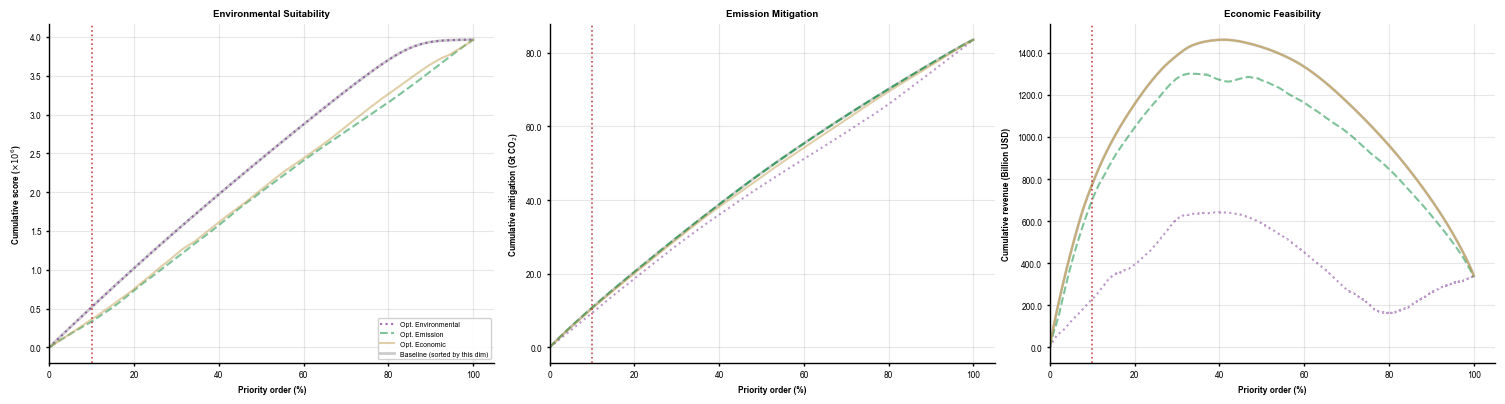

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Environmental Suitability'}, xlabel='Priority order (%)', ylabel='Cumulative score ($\\times 10^6$)'>,
        <Axes: title={'center': 'Emission Mitigation'}, xlabel='Priority order (%)', ylabel='Cumulative mitigation (Gt CO$_2$)'>,
        <Axes: title={'center': 'Economic Feasibility'}, xlabel='Priority order (%)', ylabel='Cumulative revenue (Billion USD)'>],
       dtype=object))

In [21]:
from matplotlib.ticker import FuncFormatter


def plot_single_objective_cumulative_curves(data_dict, single_results, merged_data_for_analysis, save_path=None):
    """
    绘制单目标优化结果的累积效益曲线
    
    参数:
        data_dict: 数据字典
        single_results: 单目标优化结果字典，格式为 {'A': {...}, 'B': {...}, 'C': {...}}
        merged_data_for_analysis: 原始数据DataFrame（用于计算基准曲线）
        save_path: 保存路径（可选）
    """
    # 设置字体参数
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # 颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色

    # 新增：各子图下不同线型（目标优化）对应不同颜色的映射
    # (A,B,C三种优化线条的颜色)
    single_curve_colors = {
        'A': '#7B3294',     # 更亮的紫
        'B': '#008837',     # 更亮的绿
        'C': '#C2A055'      # 更亮的棕/黄
    }

    variable_labels = {
        'A': 'Environmental Suitability',
        'B': 'Emission Mitigation',
        'C': 'Economic Feasibility'
    }
    
    obj_names = {
        'A': 'Environmental',
        'B': 'Emission',
        'C': 'Economic'
    }

    # 线型方案不变
    variable_linestyles = {
        'A': ':',        # 点线
        'B': '--',       # 虚线
        'C': '-'         # 实线
    }

    # 检查输入格式
    if isinstance(single_results, dict) and 'objective' in single_results:
        print("⚠️  警告：传入的是单个优化结果，需要运行三个单目标优化...")
        print("   请确保已运行所有三个单目标优化（A, B, C）")
        print("   或者传入格式为 {'A': {...}, 'B': {...}, 'C': {...}} 的字典")
        raise ValueError("需要传入包含 'A', 'B', 'C' 三个键的结果字典")

    # 验证 single_results 格式
    if not isinstance(single_results, dict):
        raise TypeError(f"single_results 必须是字典类型，当前类型: {type(single_results)}")

    required_keys = ['A', 'B', 'C']
    missing_keys = [key for key in required_keys if key not in single_results]
    if missing_keys:
        raise KeyError(f"single_results 缺少必要的键: {missing_keys}")

    # 验证每个结果是否包含 best_permutation
    for key in required_keys:
        if 'best_permutation' not in single_results[key]:
            raise KeyError(f"single_results['{key}'] 缺少 'best_permutation' 键")

    # ==================== 准备原始数据（参照 create_cross_target_analysis_individual） ====================
    # 检查必要的列
    required_cols = ['predicted_prob', 'Expectation_net_benefit', 'net_npv_usd', 'area_m2']
    missing_cols = [col for col in required_cols if col not in merged_data_for_analysis.columns]
    if missing_cols:
        raise ValueError(f"merged_data_for_analysis 缺少必要的列: {missing_cols}")
    
    # 准备原始数据
    data_original = merged_data_for_analysis[required_cols].copy()
    data_original = data_original.dropna().reset_index(drop=True)
    n_original = len(data_original)
    
    # 计算面积值（参照 create_cross_target_analysis_individual）
    area_values_original = data_original['area_m2'].values / 10000  # 转换为公顷
    
    # 计算三个维度的原始总效益值（参照 create_cross_target_analysis_individual）
    A_density_original = data_original['predicted_prob'].values
    A_total_original = A_density_original * area_values_original
    
    B_density_original = data_original['Expectation_net_benefit'].values / 0.27  # 单位转换
    B_total_original = B_density_original * area_values_original
    
    C_density_original = data_original['net_npv_usd'].values
    C_total_original = C_density_original * area_values_original
    
    # 维度到原始总效益值的映射
    dim_total_values = {
        'A': A_total_original,
        'B': B_total_original,
        'C': C_total_original
    }

    # 为每个维度创建子图
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 获取三个单目标优化的最佳排列
    optimal_permutations = {
        'A': single_results['A']['best_permutation'],
        'B': single_results['B']['best_permutation'],
        'C': single_results['C']['best_permutation']
    }

    # 为每个维度绘制曲线
    for dim_idx, dim in enumerate(['A', 'B', 'C']):
        ax = axes[dim_idx]

        # 绘制三个单目标优化的最佳解在该维度下的累积效益
        for obj_key in ['A', 'B', 'C']:
            perm = optimal_permutations[obj_key]
            
            # 使用原始数据计算累积效益（参照 create_cross_target_analysis_individual）
            # 获取该维度下的原始总效益值
            dim_total = dim_total_values[dim]
            
            # 按优化排序计算累积效益
            dim_sorted = dim_total[perm]
            dim_cumulative = np.cumsum(dim_sorted)
            dim_percentage = np.arange(1, len(dim_cumulative) + 1) / len(dim_cumulative) * 100
            dim_cumulative = np.concatenate([[0], dim_cumulative])
            dim_percentage = np.concatenate([[0], dim_percentage])
            
            # 在本绘图子图下，对于三种优化（线型）分别用不同颜色
            ax.plot(
                dim_percentage, 
                dim_cumulative,
                color=single_curve_colors[obj_key],    # 此处区分每个线型用自己的颜色
                linestyle=variable_linestyles[obj_key], # 每个目标优化线型不同行
                linewidth=1.5, 
                alpha=0.7 if obj_key == dim else 0.5,  # 当前维度更突出
                label=f'Opt. {obj_names[obj_key]}' if dim_idx == 0 else ''
            )
        
        # ==================== 绘制基准曲线（参照 create_cross_target_analysis_individual） ====================
        # 使用原始数据计算基准曲线（参照 create_cross_target_analysis_individual 的逻辑）
        dim_total = dim_total_values[dim]
        
        # 排序（参照 create_cross_target_analysis_individual）
        baseline_sorted_indices = np.argsort(dim_total)[::-1]
        
        # 计算累积效益（参照 create_cross_target_analysis_individual）
        baseline_cumulative = np.cumsum(dim_total[baseline_sorted_indices])
        baseline_percentage = np.arange(1, n_original + 1) / n_original * 100
        baseline_cumulative = np.concatenate([[0], baseline_cumulative])
        baseline_percentage = np.concatenate([[0], baseline_percentage])
        
        # 绘制基准曲线（灰色，较粗）
        ax.plot(baseline_percentage, baseline_cumulative,
               color='gray', 
               linestyle='-',
               linewidth=2, 
               alpha=0.4,
               label='Baseline (sorted by this dim)' if dim_idx == 0 else '',
               zorder=1)
        
        # 设置标签和格式
        ax.set_xlabel('Priority order (%)', fontsize=6, fontweight='bold')
        ax.set_ylabel(f'Cumulative {variable_labels[dim]}', fontsize=6, fontweight='bold')
        ax.set_title(variable_labels[dim], fontsize=7, fontweight='bold')
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3)
        
        # 设置Y轴格式
        if dim == 'A':
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.set_ylabel('Cumulative score ($\\times 10^6$)', fontsize=6, fontweight='bold')
        elif dim == 'B':
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('Cumulative mitigation (Gt CO$_2$)', fontsize=6, fontweight='bold')
        else:  # C
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('Cumulative revenue (Billion USD)', fontsize=6, fontweight='bold')
        
        # 坐标轴样式
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6)
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 添加10%分位线
        ax.axvline(10, color='#B71C1C', linestyle=':', linewidth=1.2, alpha=0.8, zorder=7)
    
    # 添加图例（只在第一个子图）
    axes[0].legend(loc='best', fontsize=5, framealpha=0.9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"已保存: {save_path}")

    plt.show()
    return fig, axes



plot_single_objective_cumulative_curves(
    data_dict,
    single_results,  
    merged_data_for_analysis,
    save_path="figure/US_figure/single_objective_cumulative_curves.png"
)

### 3.2 Representative Check

In [22]:
# ==================== 采样排序代表性验证和映射 ====================
import numpy as np
import pandas as pd

def verify_sample_ranking_representativeness(merged_data_for_analysis, sample_size=10000, 
                                             single_results=None, n_checks=1000):
    """
    验证采样排序是否能代表总体排序
    
    参数:
        merged_data_for_analysis: 原始数据
        sample_size: 采样大小
        single_results: 单目标优化结果（可选）
        n_checks: 检查的样本数量
    """
    print("="*80)
    print("采样排序代表性验证")
    print("="*80)
    
    # 准备原始数据
    required_cols = ['predicted_prob', 'Expectation_net_benefit', 'net_npv_usd', 'area_m2']
    data_original = merged_data_for_analysis[required_cols].copy()
    data_original = data_original.dropna().reset_index(drop=True)
    
    n_original = len(data_original)
    print(f"\n原始数据点数: {n_original:,}")
    print(f"采样大小: {sample_size:,}")
    print(f"采样比例: {sample_size/n_original*100:.2f}%")
    
    # 准备采样数据
    data_dict = prepare_optimization_data(merged_data_for_analysis, sample_size=sample_size)
    sample_indices = data_dict['original_indices']  # 采样数据在原始数据中的索引
    
    print(f"\n采样数据在原始数据中的索引范围: [{sample_indices.min()}, {sample_indices.max()}]")
    
    # 计算原始数据的排序（用于对比）
    area_values_original = data_original['area_m2'].values / 10000
    A_original = data_original['predicted_prob'].values * area_values_original
    B_original = (data_original['Expectation_net_benefit'].values / 0.27) * area_values_original
    C_original = data_original['net_npv_usd'].values * area_values_original
    
    # 原始数据的排序
    original_rank_A = np.argsort(A_original)[::-1]
    original_rank_B = np.argsort(B_original)[::-1]
    original_rank_C = np.argsort(C_original)[::-1]
    
    # 如果提供了优化结果，验证采样排序
    if single_results is not None:
        print(f"\n验证优化排序的代表性...")
        
        for obj_key in ['A', 'B', 'C']:
            if obj_key not in single_results:
                continue
                
            print(f"\n{'='*60}")
            print(f"维度 {obj_key} 的验证:")
            print(f"{'='*60}")
            
            # 获取采样数据的优化排序
            sample_permutation = single_results[obj_key]['best_permutation']
            
            # 将采样排序映射到原始数据索引
            sample_sorted_indices = sample_indices[sample_permutation]
            
            # 获取原始数据中对应样本的排序位置
            if obj_key == 'A':
                original_values = A_original
                original_rank = original_rank_A
            elif obj_key == 'B':
                original_values = B_original
                original_rank = original_rank_B
            else:
                original_values = C_original
                original_rank = original_rank_C
            
            # 检查采样排序在原始数据中的一致性
            sample_values_in_original = original_values[sample_sorted_indices]
            
            # 计算采样排序的排名（在原始数据中的位置）
            sample_ranks_in_original = np.zeros(len(sample_sorted_indices), dtype=int)
            for i, idx in enumerate(sample_sorted_indices):
                sample_ranks_in_original[i] = np.where(original_rank == idx)[0][0]
            
            # 统计前10%的样本在原始数据中的排名分布
            top_10_percent = int(len(sample_sorted_indices) * 0.1)
            top_10_ranks = sample_ranks_in_original[:top_10_percent]
            top_10_percentile_in_original = (top_10_ranks / n_original * 100)
            
            print(f"前10%样本在原始数据中的排名分布:")
            print(f"  平均排名百分位: {top_10_percentile_in_original.mean():.2f}%")
            print(f"  中位数排名百分位: {np.median(top_10_percentile_in_original):.2f}%")
            print(f"  最小排名百分位: {top_10_percentile_in_original.min():.2f}%")
            print(f"  最大排名百分位: {top_10_percentile_in_original.max():.2f}%")
            
            if top_10_percentile_in_original.mean() < 15:
                print(f"  ✅ 前10%样本在原始数据中也排名靠前（< 15%），代表性良好")
            else:
                print(f"  ⚠️  前10%样本在原始数据中排名较分散，可能需要增加采样大小")
    
    return {
        'n_original': n_original,
        'sample_size': sample_size,
        'sample_indices': sample_indices,
        'original_rank_A': original_rank_A,
        'original_rank_B': original_rank_B,
        'original_rank_C': original_rank_C
    }

def map_sample_ranking_to_original(merged_data_for_analysis, data_dict, single_results):
    """
    将采样数据的排序映射回原始数据
    
    参数:
        merged_data_for_analysis: 原始数据
        data_dict: 采样数据字典
        single_results: 单目标优化结果
    
    返回:
        dict: 包含映射后排序的字典
    """
    print("="*80)
    print("将采样排序映射到原始数据")
    print("="*80)
    
    # 准备原始数据
    required_cols = ['predicted_prob', 'Expectation_net_benefit', 'net_npv_usd', 'area_m2']
    data_original = merged_data_for_analysis[required_cols].copy()
    data_original = data_original.dropna().reset_index(drop=True)
    
    n_original = len(data_original)
    sample_indices = data_dict['original_indices']
    
    print(f"\n原始数据点数: {n_original:,}")
    print(f"采样数据点数: {len(sample_indices):,}")
    
    # 创建映射结果
    mapped_rankings = {}
    
    for obj_key in ['A', 'B', 'C']:
        if obj_key not in single_results:
            continue
        
        print(f"\n{'='*60}")
        print(f"映射维度 {obj_key} 的排序...")
        print(f"{'='*60}")
        
        # 获取采样数据的优化排序
        sample_permutation = single_results[obj_key]['best_permutation']
        
        # 将采样排序映射到原始数据索引
        sample_sorted_indices = sample_indices[sample_permutation]
        
        # 创建原始数据的完整排序
        # 策略：采样数据按优化排序，未采样数据按值排序后插入
        area_values_original = data_original['area_m2'].values / 10000
        
        if obj_key == 'A':
            original_values = data_original['predicted_prob'].values * area_values_original
        elif obj_key == 'B':
            original_values = (data_original['Expectation_net_benefit'].values / 0.27) * area_values_original
        else:
            original_values = data_original['net_npv_usd'].values * area_values_original
        
        # 获取未采样的数据索引
        all_indices = np.arange(n_original)
        unsampled_indices = np.setdiff1d(all_indices, sample_indices)
        
        # 对未采样数据按值排序
        unsampled_values = original_values[unsampled_indices]
        unsampled_sorted = unsampled_indices[np.argsort(unsampled_values)[::-1]]
        
        # 合并排序：采样数据（已优化排序）+ 未采样数据（按值排序）
        full_ranking = np.concatenate([sample_sorted_indices, unsampled_sorted])
        
        mapped_rankings[obj_key] = {
            'full_ranking': full_ranking,
            'sample_ranking': sample_sorted_indices,
            'unsampled_ranking': unsampled_sorted,
            'n_sampled': len(sample_sorted_indices),
            'n_unsampled': len(unsampled_sorted)
        }
        
        print(f"  采样数据排序: {len(sample_sorted_indices):,} 个")
        print(f"  未采样数据排序: {len(unsampled_sorted):,} 个")
        print(f"  完整排序: {len(full_ranking):,} 个")
        
        # 验证排序完整性
        if len(full_ranking) == n_original and len(np.unique(full_ranking)) == n_original:
            print(f"  ✅ 排序完整且无重复")
        else:
            print(f"  ❌ 排序有问题！")
    
    return mapped_rankings

def apply_ranking_to_original_data(merged_data_for_analysis, mapped_rankings, objective='A'):
    """
    将映射后的排序应用到原始数据，计算累积效益
    
    参数:
        merged_data_for_analysis: 原始数据
        mapped_rankings: 映射后的排序（来自map_sample_ranking_to_original）
        objective: 目标维度 ('A', 'B', 或 'C')
    
    返回:
        dict: 包含累积效益曲线的数据
    """
    print("="*80)
    print(f"在原始数据上应用排序（维度 {objective}）")
    print("="*80)
    
    # 准备原始数据
    required_cols = ['predicted_prob', 'Expectation_net_benefit', 'net_npv_usd', 'area_m2']
    data_original = merged_data_for_analysis[required_cols].copy()
    data_original = data_original.dropna().reset_index(drop=True)
    
    n_original = len(data_original)
    area_values = data_original['area_m2'].values / 10000
    
    # 计算三个维度的总效益
    A_total = data_original['predicted_prob'].values * area_values
    B_total = (data_original['Expectation_net_benefit'].values / 0.27) * area_values
    C_total = data_original['net_npv_usd'].values * area_values
    
    # 获取排序
    if objective not in mapped_rankings:
        raise ValueError(f"未找到维度 {objective} 的映射排序")
    
    ranking = mapped_rankings[objective]['full_ranking']
    
    # 按排序计算累积效益
    A_sorted = A_total[ranking]
    B_sorted = B_total[ranking]
    C_sorted = C_total[ranking]
    
    A_cumulative = np.cumsum(A_sorted)
    B_cumulative = np.cumsum(B_sorted)
    C_cumulative = np.cumsum(C_sorted)
    
    # 转换为百分比
    percentage = np.arange(1, n_original + 1) / n_original * 100
    
    # 添加起点
    A_cumulative = np.concatenate([[0], A_cumulative])
    B_cumulative = np.concatenate([[0], B_cumulative])
    C_cumulative = np.concatenate([[0], C_cumulative])
    percentage = np.concatenate([[0], percentage])
    
    print(f"\n结果:")
    print(f"  数据点数: {n_original:,}")
    print(f"  排序长度: {len(ranking):,}")
    print(f"  累积效益（A）: {A_cumulative[-1]:.2e}")
    print(f"  累积效益（B）: {B_cumulative[-1]:.2e}")
    print(f"  累积效益（C）: {C_cumulative[-1]:.2e}")
    
    return {
        'percentage': percentage,
        'A_cumulative': A_cumulative,
        'B_cumulative': B_cumulative,
        'C_cumulative': C_cumulative,
        'ranking': ranking
    }

def comprehensive_validation(merged_data_for_analysis, sample_size=10000, single_results=None):
    """
    综合验证：检查采样排序的代表性，并提供映射方案
    """
    print("="*80)
    print("综合验证：采样排序代表性")
    print("="*80)
    
    # 1. 验证代表性
    validation_result = verify_sample_ranking_representativeness(
        merged_data_for_analysis, 
        sample_size=sample_size,
        single_results=single_results
    )
    
    # 2. 如果提供了优化结果，进行映射
    if single_results is not None:
        print("\n" + "="*80)
        print("步骤2: 将采样排序映射到原始数据")
        print("="*80)
        
        # 准备数据字典（需要重新准备以获取original_indices）
        data_dict = prepare_optimization_data(merged_data_for_analysis, sample_size=sample_size)
        
        # 映射排序
        mapped_rankings = map_sample_ranking_to_original(
            merged_data_for_analysis,
            data_dict,
            single_results
        )
        
        # 3. 在原始数据上应用排序
        print("\n" + "="*80)
        print("步骤3: 在原始数据上应用排序")
        print("="*80)
        
        applied_results = {}
        for obj_key in ['A', 'B', 'C']:
            if obj_key in mapped_rankings:
                applied_results[obj_key] = apply_ranking_to_original_data(
                    merged_data_for_analysis,
                    mapped_rankings,
                    objective=obj_key
                )
        
        return {
            'validation': validation_result,
            'mapped_rankings': mapped_rankings,
            'applied_results': applied_results
        }
    else:
        return {
            'validation': validation_result,
            'mapped_rankings': None,
            'applied_results': None
        }

# ==================== 使用示例 ====================
print("\n" + "="*80)
print("采样排序代表性验证和映射")
print("="*80)




if 'single_results' in locals() or 'single_results' in globals():
    print("\n执行综合验证...")
    validation_output = comprehensive_validation(
        merged_data_for_analysis,
        sample_size=70337,
        single_results=single_results
    )
    
    print("\n" + "="*80)
    print("验证完成！")
    print("="*80)
    print("\n关键点:")
    print("1. 采样排序已映射到原始数据")
    print("2. 未采样数据按值排序后插入")
    print("3. 完整排序可以应用到全部原始数据")
    print("4. 可以使用applied_results绘制原始数据的累积效益曲线")
else:
    print("\n⚠️  未找到single_results，请先运行优化")
    print("   运行优化后，可以使用comprehensive_validation函数进行验证")


采样排序代表性验证和映射

执行综合验证...
综合验证：采样排序代表性
采样排序代表性验证

原始数据点数: 70,337
采样大小: 70,337
采样比例: 100.00%
原始数据行数: 70337
删除缺失值后行数: 70337
优化类型: all (解析法使用全量数据，不进行采样)

数据标准化完成 (min-max方法)

数据准备完成:
  - 数据点数量: 70337
  - A (环境) 原始范围: [3.92e-04, 7.75e+01], 标准化后: [0.0000, 1.0000]
  - B (减排) 原始范围: [1.87e+05, 1.87e+06], 标准化后: [0.0000, 1.0000]
  - C (经济) 原始范围: [-8.61e+07, 2.48e+08], 标准化后: [0.0000, 1.0000]
  - 权重和: 0.500000

采样数据在原始数据中的索引范围: [0, 70336]

验证优化排序的代表性...

维度 A 的验证:
前10%样本在原始数据中的排名分布:
  平均排名百分位: 5.00%
  中位数排名百分位: 5.00%
  最小排名百分位: 0.00%
  最大排名百分位: 10.00%
  ✅ 前10%样本在原始数据中也排名靠前（< 15%），代表性良好

维度 B 的验证:
前10%样本在原始数据中的排名分布:
  平均排名百分位: 5.00%
  中位数排名百分位: 5.00%
  最小排名百分位: 0.00%
  最大排名百分位: 10.00%
  ✅ 前10%样本在原始数据中也排名靠前（< 15%），代表性良好

维度 C 的验证:
前10%样本在原始数据中的排名分布:
  平均排名百分位: 5.00%
  中位数排名百分位: 5.00%
  最小排名百分位: 0.00%
  最大排名百分位: 10.00%
  ✅ 前10%样本在原始数据中也排名靠前（< 15%），代表性良好

步骤2: 将采样排序映射到原始数据
原始数据行数: 70337
删除缺失值后行数: 70337
优化类型: all (解析法使用全量数据，不进行采样)

数据标准化完成 (min-max方法)

数据准备完成:
  - 数据点数量: 70337
  - A (环境) 原始范围: [3.92e-04

# Dual-objective

In [9]:
# ==================== 双目标优化（解析法版本 - 使用加权和+非支配排序） ====================
def run_two_objective_optimization(data_dict, objectives=('A', 'B'), n_candidates=100):
    """
    运行双目标优化（解析法版本）
    
    使用加权和方法生成K个候选解，然后使用非支配排序提取Pareto前沿
    
    参数:
        data_dict: 数据字典
        objectives: 目标元组，如 ('A', 'B')
        n_candidates: 候选解数量（默认100）
    
    返回:
        result: 优化结果
    """
    from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
    
    obj_names = {'A': '环境', 'B': '减排', 'C': '经济'}
    print(f"\n{'='*60}")
    print(f"双目标优化: 最大化 (E_{objectives[0]}(π), E_{objectives[1]}(π))")
    print(f"            ({obj_names[objectives[0]]}, {obj_names[objectives[1]]})")
    print(f"使用解析法: 加权和 + 非支配排序 (候选解数量: {n_candidates})")
    print(f"{'='*60}")
    
    # 验证数据一致性
    n = data_dict['n']
    print(f"数据点数量: {n}")
    print(f"验证数据维度...")
    assert len(data_dict['A_values']) == n, f"A_values长度={len(data_dict['A_values'])}, n={n}"
    assert len(data_dict['B_values']) == n, f"B_values长度={len(data_dict['B_values'])}, n={n}"
    assert len(data_dict['C_values']) == n, f"C_values长度={len(data_dict['C_values'])}, n={n}"
    assert len(data_dict['weights']) == n, f"weights长度={len(data_dict['weights'])}, n={n}"
    print("✅ 数据维度验证通过")
    
    # 获取目标值数组
    obj_map = {
        'A': data_dict['A_values'],
        'B': data_dict['B_values'],
        'C': data_dict['C_values']
    }
    values_1 = obj_map[objectives[0]]
    values_2 = obj_map[objectives[1]]
    weights = data_dict['weights']
    
    # 生成K个候选解：对每个lambda，计算加权组合并排序
    print(f"生成 {n_candidates} 个候选解...")
    lambdas = np.linspace(0, 1, n_candidates)
    candidate_permutations = []
    candidate_objectives = []
    
    for lam in lambdas:
        # 加权组合: lambda * values_1 + (1-lambda) * values_2
        combined_values = lam * values_1 + (1 - lam) * values_2
        # 按加权组合排序（从大到小）
        perm = np.argsort(combined_values)[::-1]
        candidate_permutations.append(perm)
        
        # 计算该排列下的两个目标函数值
        E_1 = compute_efficiency(perm, values_1, weights)
        E_2 = compute_efficiency(perm, values_2, weights)
        candidate_objectives.append([E_1, E_2])
    
    candidate_objectives = np.array(candidate_objectives)
    candidate_permutations = np.array(candidate_permutations)
    
    print(f"✅ 候选解生成完成")
    print(f"  候选解数量: {len(candidate_permutations)}")
    
    # 使用非支配排序提取Pareto前沿
    print(f"执行非支配排序...")
    nds = NonDominatedSorting()
    fronts = nds.do(candidate_objectives)
    pareto_indices = fronts[0]  
    
    pareto_permutations = candidate_permutations[pareto_indices]
    pareto_objectives = candidate_objectives[pareto_indices]
    
    print(f"\n优化完成!")
    print(f"Pareto前沿解数量: {len(pareto_permutations)}")
    print(f"目标函数范围:")
    print(f"  E_{objectives[0]}: [{pareto_objectives[:, 0].min():.6e}, {pareto_objectives[:, 0].max():.6e}]")
    print(f"  E_{objectives[1]}: [{pareto_objectives[:, 1].min():.6e}, {pareto_objectives[:, 1].max():.6e}]")
    
    # 验证排列有效性（检查第一个解）
    if len(pareto_permutations) > 0:
        first_perm = pareto_permutations[0]
        if len(first_perm) != n:
            print(f"⚠️  警告: 第一个排列长度不匹配! 期望 {n}, 实际 {len(first_perm)}")
        elif len(set(first_perm)) != n:
            print(f"⚠️  警告: 第一个排列中有重复值! 唯一值数量: {len(set(first_perm))}")
        elif set(first_perm) != set(range(n)):
            print(f"⚠️  警告: 第一个排列值不在期望范围内!")
        else:
            print(f"✅ 第一个Pareto解是有效排列")
    
    # 计算所有三个维度的效率值（用于后续分析）
    all_E_A = np.array([compute_efficiency(perm, data_dict['A_values'], data_dict['weights']) 
                        for perm in pareto_permutations])
    all_E_B = np.array([compute_efficiency(perm, data_dict['B_values'], data_dict['weights']) 
                        for perm in pareto_permutations])
    all_E_C = np.array([compute_efficiency(perm, data_dict['C_values'], data_dict['weights']) 
                        for perm in pareto_permutations])
    
    
    # 计算表现效率值（使用原始值）
    print(f"\n计算表现效率值...\n")
    area_values = data_dict['area_values']
    
    # 获取原始值
    obj_map_original = {
        'A': data_dict['A_values_original'],
        'B': data_dict['B_values_original'],
        'C': data_dict['C_values_original']
    }
    original_values_1 = obj_map_original[objectives[0]]
    original_values_2 = obj_map_original[objectives[1]]
    
    # 计算每个Pareto解的表现效率
    pareto_performance_1 = np.array([
        compute_performance_efficiency(perm, original_values_1, area_values)
        for perm in pareto_permutations
    ])
    pareto_performance_2 = np.array([
        compute_performance_efficiency(perm, original_values_2, area_values)
        for perm in pareto_permutations
    ])
    
    pareto_performance_objectives = np.column_stack([pareto_performance_1, pareto_performance_2])
    
    print(f"✅ 表现效率计算完成")
    print(f"  P_{objectives[0]}: [{pareto_performance_1.min():.6e}, {pareto_performance_1.max():.6e}]")
    print(f"  P_{objectives[1]}: [{pareto_performance_2.min():.6e}, {pareto_performance_2.max():.6e}]")
    
    return {
        'problem': None,  # 不再使用pymoo问题类
        'result': None,   # 不再使用pymoo结果
        'pareto_permutations': pareto_permutations,
        'pareto_objectives': pareto_objectives,
        'all_E_A': all_E_A,
        'all_E_B': all_E_B,
        'all_E_C': all_E_C,
        'objectives': objectives,
        'pareto_performance_1': pareto_performance_1,
        'pareto_performance_2': pareto_performance_2,
        'pareto_performance_objectives': pareto_performance_objectives,
        'n_candidates': n_candidates,
    }

print("双目标优化函数（解析法版本）定义完成！")


双目标优化函数（解析法版本）定义完成！


# Triple-objective

In [23]:
# ==================== 三目标优化（解析法版本 - 使用加权和+非支配排序） ====================
def run_three_objective_optimization(data_dict, n_candidates=100):
    """
    运行三目标优化（解析法版本）
    
    使用加权和方法生成K个候选解，然后使用非支配排序提取Pareto前沿
    对于三目标，使用2D权重网格：lambda1, lambda2, lambda3，其中 lambda1 + lambda2 + lambda3 = 1
    
    参数:
        data_dict: 数据字典
        n_candidates: 候选解数量（默认100，实际会生成约sqrt(n_candidates)^2个解）
    
    返回:
        result: 优化结果
    """
    from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
    
    print(f"\n{'='*60}")
    print(f"三目标优化: 最大化 (E_A(π), E_B(π), E_C(π))")
    print(f"            (环境, 减排, 经济)")
    print(f"使用解析法: 加权和 + 非支配排序 (候选解数量: {n_candidates})")
    print(f"{'='*60}")
    
    # 验证数据一致性
    n = data_dict['n']
    print(f"数据点数量: {n}")
    print(f"验证数据维度...")
    assert len(data_dict['A_values']) == n, f"A_values长度={len(data_dict['A_values'])}, n={n}"
    assert len(data_dict['B_values']) == n, f"B_values长度={len(data_dict['B_values'])}, n={n}"
    assert len(data_dict['C_values']) == n, f"C_values长度={len(data_dict['C_values'])}, n={n}"
    assert len(data_dict['weights']) == n, f"weights长度={len(data_dict['weights'])}, n={n}"
    print("✅ 数据维度验证通过")
    
    # 获取目标值数组
    A_values = data_dict['A_values']
    B_values = data_dict['B_values']
    C_values = data_dict['C_values']
    weights = data_dict['weights']
    
    # 生成权重网格：lambda1, lambda2, lambda3，其中 lambda1 + lambda2 + lambda3 = 1
    # 使用2D网格：lambda1 和 lambda2 在 [0, 1] 范围内，lambda3 = 1 - lambda1 - lambda2
    # 确保 lambda3 >= 0
    n_grid = int(np.sqrt(n_candidates))  # 每个维度的网格点数
    lambda1_grid = np.linspace(0, 1, n_grid)
    lambda2_grid = np.linspace(0, 1, n_grid)
    
    print(f"生成权重网格 ({n_grid}x{n_grid} = {n_grid*n_grid} 个权重组合)...")
    candidate_permutations = []
    candidate_objectives = []
    weight_combinations = []
    
    for lambda1 in lambda1_grid:
        for lambda2 in lambda2_grid:
            lambda3 = 1 - lambda1 - lambda2
            # 只保留有效的权重组合（lambda3 >= 0）
            if lambda3 >= -1e-10:  # 允许小的数值误差
                # 加权组合: lambda1*A + lambda2*B + lambda3*C
                combined_values = lambda1 * A_values + lambda2 * B_values + lambda3 * C_values
                # 按加权组合排序（从大到小）
                perm = np.argsort(combined_values)[::-1]
                candidate_permutations.append(perm)
                weight_combinations.append([lambda1, lambda2, lambda3])
                
                # 计算该排列下的三个目标函数值
                E_A = compute_efficiency(perm, A_values, weights)
                E_B = compute_efficiency(perm, B_values, weights)
                E_C = compute_efficiency(perm, C_values, weights)
                candidate_objectives.append([E_A, E_B, E_C])
    
    candidate_objectives = np.array(candidate_objectives)
    candidate_permutations = np.array(candidate_permutations)
    weight_combinations = np.array(weight_combinations)
    
    print(f"✅ 候选解生成完成")
    print(f"  有效候选解数量: {len(candidate_permutations)}")
    
    # 使用非支配排序提取Pareto前沿
    print(f"执行非支配排序...")
    nds = NonDominatedSorting()
    fronts = nds.do(candidate_objectives)
    pareto_indices = fronts[0]  # 第一层前沿是Pareto最优解
    
    pareto_permutations = candidate_permutations[pareto_indices]
    pareto_objectives = candidate_objectives[pareto_indices]
    
    print(f"\n优化完成!")
    print(f"Pareto前沿解数量: {len(pareto_permutations)}")
    print(f"目标函数范围:")
    print(f"  E_A: [{pareto_objectives[:, 0].min():.6e}, {pareto_objectives[:, 0].max():.6e}]")
    print(f"  E_B: [{pareto_objectives[:, 1].min():.6e}, {pareto_objectives[:, 1].max():.6e}]")
    print(f"  E_C: [{pareto_objectives[:, 2].min():.6e}, {pareto_objectives[:, 2].max():.6e}]")
    
    # 验证排列有效性（检查第一个解）
    if len(pareto_permutations) > 0:
        first_perm = pareto_permutations[0]
        if len(first_perm) != n:
            print(f"⚠️  警告: 第一个排列长度不匹配! 期望 {n}, 实际 {len(first_perm)}")
        elif len(set(first_perm)) != n:
            print(f"⚠️  警告: 第一个排列中有重复值! 唯一值数量: {len(set(first_perm))}")
        elif set(first_perm) != set(range(n)):
            print(f"⚠️  警告: 第一个排列值不在期望范围内!")
        else:
            print(f"✅ 第一个Pareto解是有效排列")

    # 拟合超平面: ax + by + cz + d = 0
    # 使用最小二乘法拟合平面
    print(f"\n拟合超平面...")
    if len(pareto_objectives) >= 3:
        # 准备数据点
        points = pareto_objectives  # shape: (n_points, 3)
        
        # 构建线性方程组: z = ax + by + c 或 ax + by + cz + d = 0
        # 使用形式: z = a*x + b*y + c，转换为 ax + by - z + c = 0
        # 即: ax + by + (-1)*z + c = 0
        X = points[:, [0, 1]]  # x, y
        y = points[:, 2]  # z
        
        # 最小二乘拟合: z = a*x + b*y + c
        A_fit = np.column_stack([X, np.ones(len(X))])
        coeffs, residuals, rank, s = np.linalg.lstsq(A_fit, y, rcond=None)
        a, b, c = coeffs[0], coeffs[1], coeffs[2]
        
        # 转换为标准形式: ax + by - z + c = 0 或 ax + by + cz + d = 0
        # 这里使用 ax + by + (-1)*z + c = 0，所以系数为 [a, b, -1, c]
        plane_coeffs = np.array([a, b, -1.0, c])
        
        # 归一化系数
        norm = np.linalg.norm(plane_coeffs[:3])
        if norm > 1e-10:
            plane_coeffs = plane_coeffs / norm
        
        # 计算拟合误差
        predicted_z = a * points[:, 0] + b * points[:, 1] + c
        fit_error = np.mean(np.abs(predicted_z - points[:, 2]))
        max_error = np.max(np.abs(predicted_z - points[:, 2]))
        
        print(f"✅ 超平面拟合完成")
        print(f"  超平面方程: {plane_coeffs[0]:.6f}*E_A + {plane_coeffs[1]:.6f}*E_B + {plane_coeffs[2]:.6f}*E_C + {plane_coeffs[3]:.6f} = 0")
        print(f"  平均拟合误差: {fit_error:.6e}")
        print(f"  最大拟合误差: {max_error:.6e}")
        
        hyperplane_params = {
            'coefficients': plane_coeffs,  # [a, b, c, d] for ax + by + cz + d = 0
            'mean_error': fit_error,
            'max_error': max_error,
            'fit_form': 'z = a*x + b*y + c',
            'fit_coeffs': [a, b, c]  # for z = a*x + b*y + c
        }
    else:
        print(f"⚠️  警告: Pareto前沿解数量太少（{len(pareto_objectives)}），无法拟合超平面（至少需要3个点）")
        hyperplane_params = None
    
    
    # 计算表现效率值（使用原始值）
    print(f"\n计算表现效率值...\n")
    area_values = data_dict['area_values']
    
    # 获取原始值
    A_values_original = data_dict['A_values_original']
    B_values_original = data_dict['B_values_original']
    C_values_original = data_dict['C_values_original']
    
    # 计算每个Pareto解的表现效率
    pareto_performance_A = np.array([
        compute_performance_efficiency(perm, A_values_original, area_values)
        for perm in pareto_permutations
    ])
    pareto_performance_B = np.array([
        compute_performance_efficiency(perm, B_values_original, area_values)
        for perm in pareto_permutations
    ])
    pareto_performance_C = np.array([
        compute_performance_efficiency(perm, C_values_original, area_values)
        for perm in pareto_permutations
    ])
    
    pareto_performance_objectives = np.column_stack([
        pareto_performance_A,
        pareto_performance_B,
        pareto_performance_C
    ])
    
    print(f"✅ 表现效率计算完成")
    print(f"  P_A: [{pareto_performance_A.min():.6e}, {pareto_performance_A.max():.6e}]")
    print(f"  P_B: [{pareto_performance_B.min():.6e}, {pareto_performance_B.max():.6e}]")
    print(f"  P_C: [{pareto_performance_C.min():.6e}, {pareto_performance_C.max():.6e}]")
    
    return {
        'problem': None,  # 不再使用pymoo问题类
        'result': None,   # 不再使用pymoo结果
        'pareto_permutations': pareto_permutations,
        'pareto_objectives': pareto_objectives,
        'objectives': ('A', 'B', 'C'),
        'n_candidates': len(candidate_permutations),
        'hyperplane': hyperplane_params,
        'pareto_performance_A': pareto_performance_A,
        'pareto_performance_B': pareto_performance_B,
        'pareto_performance_C': pareto_performance_C,
        'pareto_performance_objectives': pareto_performance_objectives
    }

print("三目标优化函数（解析法版本）定义完成！")



三目标优化函数（解析法版本）定义完成！


## Kernals optimization 3D

In [24]:
# ==================== Policy-aware 多目标优化框架 ====================

def generate_lambda_grid(n_candidates=5000, method='simplex'):
    """
    生成宏观偏好 lambda 网格
    
    参数:
        n_candidates: 候选解数量（默认5000）
        method: 生成方法，'simplex'（整数划分）或 'dirichlet'（随机采样）
    
    返回:
        lambda_grid: numpy数组，形状为 (n_lambdas, 3)，每行是 [lambda1, lambda2, lambda3]
                    满足 lambda1 + lambda2 + lambda3 = 1 且所有值 >= 0
    """
    if method == 'simplex':
        # 使用整数划分方法生成simplex网格
        # 对于三目标，生成所有满足 i + j + k = n_grid 的非负整数组合
        n_grid = int(np.sqrt(n_candidates * 2))  # 调整网格大小以接近目标数量
        lambda_grid = []
        
        for i in range(n_grid + 1):
            for j in range(n_grid + 1 - i):
                k = n_grid - i - j
                if k >= 0:
                    # 归一化
                    lam1 = i / n_grid
                    lam2 = j / n_grid
                    lam3 = k / n_grid
                    lambda_grid.append([lam1, lam2, lam3])
        
        lambda_grid = np.array(lambda_grid)
        
        # 如果生成的点太多，随机采样
        if len(lambda_grid) > n_candidates:
            indices = np.random.choice(len(lambda_grid), n_candidates, replace=False)
            lambda_grid = lambda_grid[indices]
        
    elif method == 'dirichlet':
        # 使用Dirichlet分布随机采样
        # Dirichlet(alpha=[1,1,1]) 在simplex上均匀分布
        alpha = np.ones(3)
        lambda_grid = np.random.dirichlet(alpha, size=n_candidates)
        
    else:
        raise ValueError(f"未知的方法: {method}，支持 'simplex' 或 'dirichlet'")
    
    # 确保归一化和非负性
    lambda_grid = np.clip(lambda_grid, 0.0, None)
    lambda_grid = lambda_grid / (lambda_grid.sum(axis=1, keepdims=True) + 1e-12)
    
    return lambda_grid


In [25]:
def build_policy_aware_permutation(A_values, B_values, C_values,
                                   lam1, lam2, lam3,
                                   kernel_weights):
    """
    根据宏观偏好 lambda 和分位注意力核 weights 构建 Policy-aware 排序 π
    
    思路：
    - 先按 S_i = lambda·(A,B,C) 降序得到像元能力排序
    - 再按 kernel_weights 降序得到"注意力最高的位置"排序
    - 将最高 S_i 分配给注意力最高的位置，以此类推
    
    参数:
        A_values: A维度值数组
        B_values: B维度值数组
        C_values: C维度值数组
        lam1, lam2, lam3: 宏观偏好权重（lambda1, lambda2, lambda3）
        kernel_weights: 分位注意力核权重数组
    
    返回:
        perm: 排列数组，perm[pos] = 像元索引
    """
    A_values = np.asarray(A_values)
    B_values = np.asarray(B_values)
    C_values = np.asarray(C_values)
    kernel_weights = np.asarray(kernel_weights)

    n = len(A_values)
    assert len(B_values) == n and len(C_values) == n
    assert len(kernel_weights) == n

    # 1. 像元综合分数（宏观偏好）
    scores = lam1 * A_values + lam2 * B_values + lam3 * C_values
    idx_sorted_by_score = np.argsort(scores)[::-1]  # 从大到小

    # 2. 位置按核权重排序：谁被"关注"更多
    positions = np.arange(n)
    idx_positions_by_weight = np.argsort(kernel_weights)[::-1]  # 权重大的位置优先

    # 3. 构建 permutation：
    #    perm[pos] = 像元索引
    perm = np.empty(n, dtype=np.int64)
    perm[idx_positions_by_weight] = idx_sorted_by_score

    return perm


In [26]:

def run_three_objective_optimization_with_kernel(
    data_dict,
    n_candidates=5000,
    kernel_type='decreasing',
    lambda_grid=None,
    lambda_grid_method='simplex',
    verbose=True,
):
    """
    运行三目标优化（支持不同核函数）- Policy-aware 版本
    
    使用宏观偏好λ和分位注意力核显式分离的优化框架
    
    参数:
        data_dict: 数据字典
        n_candidates: 候选解数量（默认5000）
        kernel_type: 核函数类型，'decreasing'（递减核）、'gaussian'（正态核）或'increasing'（递增核）
        lambda_grid: 预定义的lambda网格（可选）
        lambda_grid_method: lambda网格生成方法，'simplex'或'dirichlet'（默认'simplex'）
        verbose: 是否打印详细信息（默认True）
    
    返回:
        result: 优化结果字典，包含完整的候选解和Pareto解数据
    """
    from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

    if verbose:
        kernel_names = {
            'decreasing': '效率前沿（递减核）',
            'gaussian':  '稳健前沿（高斯核）',
            'increasing': '公平前沿（递增核）'
        }
        print(f"\n{'='*70}")
        print(f"Policy-aware Priority: 三目标优化 (kernel={kernel_type})")
        print(f"Interpretation: {kernel_names.get(kernel_type, kernel_type)}")
        print(f"{'='*70}")
    
        # ---------- 0. 数据检查 ----------
    n = data_dict['n']
    A_values = np.asarray(data_dict['A_values'])
    B_values = np.asarray(data_dict['B_values'])
    C_values = np.asarray(data_dict['C_values'])

    assert len(A_values) == n and len(B_values) == n and len(C_values) == n
    if verbose:
        print(f"数据点数量: {n}")
        print("✅ 数据维度验证通过")

    # 分位注意力核权重（这里是真正参与"排序构造"和"效率计算"的）
    kernel_weights = compute_weights(n, kernel_type=kernel_type)
    
        # ---------- 1. 生成 lambda 网格 ----------
    if lambda_grid is None:
        lambda_grid = generate_lambda_grid(
            n_candidates=n_candidates,
            method=lambda_grid_method
        )
    else:
        lambda_grid = np.asarray(lambda_grid, dtype=float)

    # 归一化 lambda，保证非负且和为 1
    lambda_grid = np.clip(lambda_grid, 0.0, None)
    lambda_grid = lambda_grid / (lambda_grid.sum(axis=1, keepdims=True) + 1e-12)
    n_lambdas = lambda_grid.shape[0]

    if verbose:
        print(f"宏观偏好候选数量: {n_lambdas}")

    # ---------- 2. 对每个 lambda 构建"Policy-aware 排序"并计算核效率 ----------
    candidate_permutations = []
    candidate_objectives = []

    # 位置按 kernel 权重排序，只需算一次
    n_pos = n
    positions = np.arange(n_pos)
    idx_positions_by_weight = np.argsort(kernel_weights)[::-1]  # 权重大 → 前

    for idx, (lam1, lam2, lam3) in enumerate(lambda_grid):
        # 使用 build_policy_aware_permutation 构建排序
        perm = build_policy_aware_permutation(
            A_values, B_values, C_values,
            lam1, lam2, lam3,
            kernel_weights
        )

        candidate_permutations.append(perm)

        # 分位注意力核效率（3E）
        E_A = compute_efficiency(perm, A_values, weights=kernel_weights)
        E_B = compute_efficiency(perm, B_values, weights=kernel_weights)
        E_C = compute_efficiency(perm, C_values, weights=kernel_weights)
        candidate_objectives.append([E_A, E_B, E_C])

        if verbose and (idx + 1) % max(1, n_lambdas // 5) == 0:
            print(f"  已处理 lambda 组合 {idx+1}/{n_lambdas}")

    candidate_permutations = np.array(candidate_permutations, dtype=np.int64)
    candidate_objectives = np.array(candidate_objectives, dtype=float)

    if verbose:
        print(f"✅ 候选解生成完成（共 {len(candidate_permutations)} 个 Policy-aware 排序）")
    
        # ---------- 3. 非支配排序：核效率 Pareto 前沿 ----------
    if verbose:
        print("执行非支配排序以提取核效率 Pareto 前沿...")

    nds = NonDominatedSorting()
    fronts = nds.do(candidate_objectives)
    pareto_indices = fronts[0]

    pareto_permutations = candidate_permutations[pareto_indices]
    pareto_objectives = candidate_objectives[pareto_indices]
    pareto_lambdas = lambda_grid[pareto_indices]

    if verbose:
        print(f"\n优化完成! Pareto 前沿解数量: {len(pareto_permutations)}")
        print("核效率范围 (E_A, E_B, E_C):")
        print(f"  E_A: [{pareto_objectives[:, 0].min():.6e}, {pareto_objectives[:, 0].max():.6e}]")
        print(f"  E_B: [{pareto_objectives[:, 1].min():.6e}, {pareto_objectives[:, 1].max():.6e}]")
        print(f"  E_C: [{pareto_objectives[:, 2].min():.6e}, {pareto_objectives[:, 2].max():.6e}]")

    # ---------- 4. 表现效率 P_A, P_B, P_C（沿用你原来的定义） ----------
    if verbose:
        print("\n计算所有候选解的表现效率值 (P_A, P_B, P_C)...")

    area_values = np.asarray(data_dict["area_values"])
    A_orig = np.asarray(data_dict["A_values_original"])
    B_orig = np.asarray(data_dict["B_values_original"])
    C_orig = np.asarray(data_dict["C_values_original"])

    candidate_performance_A = np.array([
        compute_performance_efficiency(perm, A_orig, area_values)
        for perm in candidate_permutations
    ])
    candidate_performance_B = np.array([
        compute_performance_efficiency(perm, B_orig, area_values)
        for perm in candidate_permutations
    ])
    candidate_performance_C = np.array([
        compute_performance_efficiency(perm, C_orig, area_values)
        for perm in candidate_permutations
    ])
    candidate_performance_objectives = np.column_stack(
        [candidate_performance_A, candidate_performance_B, candidate_performance_C]
    )

    # Pareto 部分直接索引
    pareto_performance_A = candidate_performance_A[pareto_indices]
    pareto_performance_B = candidate_performance_B[pareto_indices]
    pareto_performance_C = candidate_performance_C[pareto_indices]
    pareto_performance_objectives = np.column_stack(
        [pareto_performance_A, pareto_performance_B, pareto_performance_C]
    )

    if verbose:
        print("\n✅ Pareto 前沿解的表现效率计算完成")
        print(f"  P_A: [{pareto_performance_A.min():.6e}, {pareto_performance_A.max():.6e}]")
        print(f"  P_B: [{pareto_performance_B.min():.6e}, {pareto_performance_B.max():.6e}]")
        print(f"  P_C: [{pareto_performance_C.min():.6e}, {pareto_performance_C.max():.6e}]")
    
    candidate_performance_objectives = np.column_stack([
        candidate_performance_A,
        candidate_performance_B,
        candidate_performance_C
    ])
    print(f"✅ 所有候选解表现效率计算完成（共 {len(candidate_performance_objectives)} 个解）")
    
    # 计算表现效率值（使用原始值，固定积分方式）- 仅Pareto解用于返回
    print(f"\n计算Pareto解表现效率值...")
    area_values = data_dict['area_values']
    A_values_original = data_dict['A_values_original']
    B_values_original = data_dict['B_values_original']
    C_values_original = data_dict['C_values_original']
    
    pareto_performance_A = np.array([
        compute_performance_efficiency(perm, A_values_original, area_values)
        for perm in pareto_permutations
    ])
    pareto_performance_B = np.array([
        compute_performance_efficiency(perm, B_values_original, area_values)
        for perm in pareto_permutations
    ])
    pareto_performance_C = np.array([
        compute_performance_efficiency(perm, C_values_original, area_values)
        for perm in pareto_permutations
    ])
    
    pareto_performance_objectives = np.column_stack([
        pareto_performance_A,
        pareto_performance_B,
        pareto_performance_C
    ])
    
    print(f"✅ 表现效率计算完成")
    print(f"  P_A: [{pareto_performance_A.min():.6e}, {pareto_performance_A.max():.6e}]")
    print(f"  P_B: [{pareto_performance_B.min():.6e}, {pareto_performance_B.max():.6e}]")
    print(f"  P_C: [{pareto_performance_C.min():.6e}, {pareto_performance_C.max():.6e}]")
    
    return {
        "pareto_permutations": pareto_permutations,
        "pareto_objectives": pareto_objectives,
        "pareto_performance_objectives": pareto_performance_objectives,
        "pareto_lambdas": pareto_lambdas,
        "objectives": ("A", "B", "C"),
        "kernel_type": kernel_type,
        "kernel_weights": kernel_weights,
        "n_candidates": len(candidate_permutations),
        "candidate_permutations": candidate_permutations,
        "candidate_objectives": candidate_objectives,
        "candidate_performance_objectives": candidate_performance_objectives,
        "lambda_grid": lambda_grid,
    }


def locate_solution_in_frontier(coordination_performance, pareto_performance_objectives):
    """
    计算协同方案在绩效前沿中的位置
    
    参数:
        coordination_performance: 协同方案的表现效率向量，形状为 (3,)，[P_A, P_B, P_C]
        pareto_performance_objectives: Pareto前沿的表现效率矩阵，形状为 (n, 3)
    
    返回:
        location_info: 包含距离、百分位排名、区域分类的字典
    """
    coordination_performance = np.asarray(coordination_performance)
    pareto_performance_objectives = np.asarray(pareto_performance_objectives)
    
    # 计算到前沿的最小距离（欧氏距离）
    distances = np.sqrt(np.sum((pareto_performance_objectives - coordination_performance)**2, axis=1))
    min_distance = np.min(distances)
    nearest_idx = np.argmin(distances)
    
    # 计算每个维度的百分位排名
    percentile_ranks = {}
    for i, dim_name in enumerate(['P_A', 'P_B', 'P_C']):
        pareto_values = pareto_performance_objectives[:, i]
        coord_value = coordination_performance[i]
        # 百分位排名：小于该值的解的比例 * 100
        percentile_rank = (pareto_values < coord_value).mean() * 100
        percentile_ranks[dim_name] = percentile_rank
    
    # 计算平均效率的百分位排名
    pareto_avg = pareto_performance_objectives.mean(axis=1)
    coord_avg = coordination_performance.mean()
    avg_percentile_rank = (pareto_avg < coord_avg).mean() * 100
    percentile_ranks['average'] = avg_percentile_rank
    
    # 区域分类
    if avg_percentile_rank >= 90:
        region = '高效区域（top 10%）'
    elif avg_percentile_rank >= 80:
        region = '中等区域（top 20%）'
    elif avg_percentile_rank >= 70:
        region = '一般区域（top 30%）'
    else:
        region = '较低区域（< 70%）'
    
    return {
        'min_distance': min_distance,
        'nearest_idx': nearest_idx,
        'percentile_ranks': percentile_ranks,
        'region': region,
        'coordination_performance': coordination_performance,
        'nearest_frontier_point': pareto_performance_objectives[nearest_idx]
    }
def analyze_candidate_solutions(three_obj_result):
    """
    分析所有候选解的表现效率，生成详细的DataFrame并找出综合排名最靠前的解
    
    参数:
        three_obj_result: 三目标优化结果字典（必须包含candidate_performance_objectives）
    
    返回:
        dict: 包含以下键的字典
            - 'df': DataFrame，包含每个候选点的详细信息
            - 'top_composite_ranked': 综合排名最靠前的N个解的详细信息
            - 'top30_all_dimensions': 所有维度都在TOP30%的解的详细信息
    """
    import pandas as pd
    
    if 'candidate_performance_objectives' not in three_obj_result:
        print("⚠️  警告: three_obj_result中未找到candidate_performance_objectives")
        return None
    
    candidate_perf = three_obj_result['candidate_performance_objectives']
    n_candidates = len(candidate_perf)
    
    print(f"\n{'='*60}")
    print(f"候选解详细分析（共 {n_candidates} 个候选解）")
    print(f"{'='*60}")
    
    # 提取各个维度的表现效率
    P_A = candidate_perf[:, 0]
    P_B = candidate_perf[:, 1]
    P_C = candidate_perf[:, 2]
    
    # 计算每个维度在各候选解中的排名（百分位排名，从高到低）
    # 使用scipy.stats.rankdata，percentile rank = (rank - 1) / (n - 1) * 100
    from scipy.stats import rankdata
    
    # rankdata默认从低到高排名，使用pct=True得到0-1的百分比排名
    # 但我们想要从高到低的排名，所以先取负值，然后再转换
    rank_A_pct = (1 - rankdata(P_A, method='average') / (n_candidates + 1)) * 100
    rank_B_pct = (1 - rankdata(P_B, method='average') / (n_candidates + 1)) * 100
    rank_C_pct = (1 - rankdata(P_C, method='average') / (n_candidates + 1)) * 100
    
    # 计算综合得分（标准化后等权重平均）
    P_A_norm = (P_A - P_A.min()) / (P_A.max() - P_A.min() + 1e-10)
    P_B_norm = (P_B - P_B.min()) / (P_B.max() - P_B.min() + 1e-10)
    P_C_norm = (P_C - P_C.min()) / (P_C.max() - P_C.min() + 1e-10)
    
    composite_score = (P_A_norm + P_B_norm + P_C_norm) / 3.0
    
    # 综合排名（从高到低，百分位排名）
    composite_rank_pct = (1 - rankdata(composite_score, method='average') / (n_candidates + 1)) * 100
    
    # 创建DataFrame
    df = pd.DataFrame({
        'solution_id': np.arange(n_candidates),
        'P_A': P_A,
        'P_B': P_B,
        'P_C': P_C,
        'rank_P_A_pct': rank_A_pct,
        'rank_P_B_pct': rank_B_pct,
        'rank_P_C_pct': rank_C_pct,
        'composite_score': composite_score,
        'composite_rank_pct': composite_rank_pct,
        'P_A_norm': P_A_norm,
        'P_B_norm': P_B_norm,
        'P_C_norm': P_C_norm
    })
    
    # 按综合排名排序（从高到低）
    df = df.sort_values('composite_rank_pct', ascending=False).reset_index(drop=True)
    
    print(f"\n✅ DataFrame创建完成")
    print(f"   DataFrame形状: {df.shape}")
    print(f"   列名: {list(df.columns)}")
    
    # 找出综合排名最靠前的10个解
    top_n = min(10, len(df))
    top_composite_ranked = df.head(top_n).copy()
    
    print(f"\n{'='*60}")
    print(f"综合排名最靠前的 {top_n} 个解:")
    print(f"{'='*60}")
    print(f"{'排名':<6} {'P_A排名%':<10} {'P_B排名%':<10} {'P_C排名%':<10} {'综合排名%':<10}")
    print(f"{'-'*60}")
    for idx, row in top_composite_ranked.iterrows():
        print(f"{idx+1:<6} {row['rank_P_A_pct']:>9.2f}  {row['rank_P_B_pct']:>9.2f}  {row['rank_P_C_pct']:>9.2f}  {row['composite_rank_pct']:>9.2f}")
    
    # 找出所有维度都在TOP30%的解
    top30_mask = (
        (df['rank_P_A_pct'] >= 70) &  # TOP30%意味着百分位排名 >= 70
        (df['rank_P_B_pct'] >= 70) &
        (df['rank_P_C_pct'] >= 70)
    )
    top30_all_dimensions = df[top30_mask].copy()
    
    print(f"\n{'='*60}")
    print(f"所有维度都在TOP30%的解: {len(top30_all_dimensions)} 个")
    print(f"{'='*60}")
    if len(top30_all_dimensions) > 0:
        print(f"{'排名':<6} {'综合排名%':<12} {'P_A排名%':<12} {'P_B排名%':<12} {'P_C排名%':<12}")
        print(f"{'-'*60}")
        for idx, row in top30_all_dimensions.head(20).iterrows():  # 只显示前20个
            print(f"{row.name+1:<6} {row['composite_rank_pct']:>11.2f}  {row['rank_P_A_pct']:>11.2f}  {row['rank_P_B_pct']:>11.2f}  {row['rank_P_C_pct']:>11.2f}")
        if len(top30_all_dimensions) > 20:
            print(f"... (还有 {len(top30_all_dimensions) - 20} 个解)")
    else:
        print("⚠️  未找到所有维度都在TOP30%的解")
    
    # 统计信息
    print(f"\n{'='*60}")
    print(f"统计摘要:")
    print(f"{'='*60}")
    print(f"  各维度排名范围:")
    print(f"    P_A: {df['rank_P_A_pct'].min():.2f}% - {df['rank_P_A_pct'].max():.2f}%")
    print(f"    P_B: {df['rank_P_B_pct'].min():.2f}% - {df['rank_P_B_pct'].max():.2f}%")
    print(f"    P_C: {df['rank_P_C_pct'].min():.2f}% - {df['rank_P_C_pct'].max():.2f}%")
    print(f"  综合排名范围: {df['composite_rank_pct'].min():.2f}% - {df['composite_rank_pct'].max():.2f}%")
    
    return {
        'df': df,
        'top_composite_ranked': top_composite_ranked,
        'top30_all_dimensions': top30_all_dimensions,
        'n_candidates': n_candidates,
        'n_top30_all_dim': len(top30_all_dimensions)
    }




def analyze_coordination_across_kernels(coordination_performance, frontiers_dict):
    """
    综合分析协同方案在不同核函数下的位置
    
    参数:
        coordination_performance: 协同方案的表现效率向量，形状为 (3,)
        frontiers_dict: 字典，键为kernel_type，值为run_three_objective_optimization_with_kernel的返回结果
    
    返回:
        analysis_report: 分析报告字典
    """
    results = {}
    
    for kernel_type, frontier_result in frontiers_dict.items():
        location = locate_solution_in_frontier(
            coordination_performance,
            frontier_result['pareto_performance_objectives']
        )
        results[kernel_type] = location
    
    # 生成报告
    report_lines = []
    report_lines.append("\n" + "="*80)
    report_lines.append("协同方案在不同核函数下的绩效前沿位置分析")
    report_lines.append("="*80)
    
    for kernel_type, location in results.items():
        kernel_names = {
            'decreasing': '效率前沿（递减核）',
            'gaussian': '正态前沿（正态核）',
            'increasing': '公平前沿（递增核）'
        }
        report_lines.append(f"\n{kernel_names.get(kernel_type, kernel_type)}:")
        report_lines.append(f"  百分位排名（平均）: {location['percentile_ranks']['average']:.2f}%")
        report_lines.append(f"  区域分类: {location['region']}")
        report_lines.append(f"  到前沿最小距离: {location['min_distance']:.6e}")
        report_lines.append(f"  各维度百分位排名:")
        for dim, rank in location['percentile_ranks'].items():
            if dim != 'average':
                report_lines.append(f"    {dim}: {rank:.2f}%")
    
    # 判断是否支持"协同即高效"假设
    all_high_performance = all(
        r['percentile_ranks']['average'] >= 80 
        for r in results.values()
    )
    all_top_10 = all(
        r['percentile_ranks']['average'] >= 90 
        for r in results.values()
    )
    
    report_lines.append("\n" + "="*80)
    report_lines.append("结论:")
    if all_top_10:
        report_lines.append("✅ 协同方案在所有核函数下都处于高效区域（top 10%），")
        report_lines.append("   强烈支持'协同即高效'假设")
    elif all_high_performance:
        report_lines.append("✅ 协同方案在所有核函数下都接近前沿（top 20%），")
        report_lines.append("   支持'协同即高效'假设")
    else:
        report_lines.append("⚠️  协同方案在某些核函数下未达到高效区域，")
        report_lines.append("   需要进一步分析")
    report_lines.append("="*80)
    
    report_text = "\n".join(report_lines)
    print(report_text)
    
    return {
        'results': results,
        'all_high_performance': all_high_performance,
        'all_top_10': all_top_10,
        'report': report_text
    }



# Pareto_frontier curve

In [27]:
def plot_cumulative_benefits_for_permutation(permutation, data_dict, label='Solution', 
                                             color=None, linestyle='-', alpha=0.8):
    """
    为给定排列绘制三个维度的累积效益曲线
    
    参数:
        permutation: 排列数组
        data_dict: 数据字典
        label: 图例标签
        color: 颜色（可选）
        linestyle: 线型
        alpha: 透明度
    
    返回:
        curves_data: 包含三个维度曲线数据的字典
    """
    n = len(permutation)
    area_values = data_dict['area_values']
    
    # 获取三个维度的总效益值（使用原始值，非标准化值）
    A_total = data_dict['A_values_original']
    B_total = data_dict['B_values_original']
    C_total = data_dict['C_values_original']
    
    # 按排列顺序计算累积效益
    A_sorted = A_total[permutation]
    B_sorted = B_total[permutation]
    C_sorted = C_total[permutation]
    
    A_cumulative = np.cumsum(A_sorted)
    B_cumulative = np.cumsum(B_sorted)
    C_cumulative = np.cumsum(C_sorted)
    
    # 转换为百分比
    percentage = np.arange(1, n + 1) / n * 100
    
    # 添加起点 (0, 0)
    A_cumulative = np.concatenate([[0], A_cumulative])
    B_cumulative = np.concatenate([[0], B_cumulative])
    C_cumulative = np.concatenate([[0], C_cumulative])
    percentage = np.concatenate([[0], percentage])
    
    curves_data = {
        'A': {'percentage': percentage, 'benefits': A_cumulative, 'label': 'Environmental'},
        'B': {'percentage': percentage, 'benefits': B_cumulative, 'label': 'Emission'},
        'C': {'percentage': percentage, 'benefits': C_cumulative, 'label': 'Economic'},
        'label': label,
        'color': color,
        'linestyle': linestyle,
        'alpha': alpha
    }
    
    return curves_data

In [28]:
# ==================== Pareto frontier visualization ====================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Color scheme (consistent with existing code)
env_color = '#542788'       # Purple
carbon_color = '#00441b'    # Green
economic_color = '#bf812d'  # Brown

def plot_pareto_frontier_2d(two_obj_result, save_path=None):
    """
    绘制双目标Pareto前沿

    参数:
        two_obj_result: 双目标优化结果字典
        save_path: 保存路径（可选）
    """
    obj_names = {'A': ('Environment (E_A)', env_color), 
                 'B': ('Emission Reduction (E_B)', carbon_color), 
                 'C': ('Economics (E_C)', economic_color)}
    
    objectives = two_obj_result['objectives']
    pareto_obj = two_obj_result['pareto_objectives']
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot Pareto frontier
    ax.scatter(pareto_obj[:, 0], pareto_obj[:, 1], 
               c=obj_names[objectives[1]][1], 
               alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
    
    # Set labels
    ax.set_xlabel(f'{obj_names[objectives[0]][0]}', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{obj_names[objectives[1]][0]}', fontsize=12, fontweight='bold')
    ax.set_title(f'Pareto Frontier: ({obj_names[objectives[0]][0]}, {obj_names[objectives[1]][0]})', 
                 fontsize=14, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, ax

def plot_pareto_frontier_3d(three_obj_result, save_path=None):
    """
    绘制三目标Pareto前沿（3D散点图）

    参数:
        three_obj_result: 三目标优化结果字典
        save_path: 保存路径（可选）
    """
    pareto_obj = three_obj_result['pareto_objectives']
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot Pareto frontier
    scatter = ax.scatter(pareto_obj[:, 0], pareto_obj[:, 1], pareto_obj[:, 2],
                         c=pareto_obj[:, 2], cmap='viridis', 
                         alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
    
    # Set labels
    ax.set_xlabel('Environment (E_A)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Emission Reduction (E_B)', fontsize=11, fontweight='bold')
    ax.set_zlabel('Economics (E_C)', fontsize=11, fontweight='bold')
    ax.set_title('Pareto Frontier (3-objective)', fontsize=14, fontweight='bold')
    
    # 绘制拟合的超平面
    if 'hyperplane' in three_obj_result and three_obj_result['hyperplane'] is not None:
        hyperplane = three_obj_result['hyperplane']
        fit_coeffs = hyperplane['fit_coeffs']  # [a, b, c] for z = a*x + b*y + c
        
        # 创建网格用于绘制平面
        x_range = [pareto_obj[:, 0].min(), pareto_obj[:, 0].max()]
        y_range = [pareto_obj[:, 1].min(), pareto_obj[:, 1].max()]
        
        # 扩展范围以便更好地显示
        x_span = x_range[1] - x_range[0]
        y_span = y_range[1] - y_range[0]
        x_range = [x_range[0] - 0.1*x_span, x_range[1] + 0.1*x_span]
        y_range = [y_range[0] - 0.1*y_span, y_range[1] + 0.1*y_span]
        
        # 创建网格
        x_plane = np.linspace(x_range[0], x_range[1], 20)
        y_plane = np.linspace(y_range[0], y_range[1], 20)
        X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
        
        # 计算平面上的z值: z = a*x + b*y + c
        Z_plane = fit_coeffs[0] * X_plane + fit_coeffs[1] * Y_plane + fit_coeffs[2]
        
        # 绘制平面
        ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color='red', 
                       label='Fitted Hyperplane', edgecolor='none')
        
        print(f"✅ 超平面已绘制在图中")
    
        # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Economics (E_C)', shrink=0.8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, ax

def plot_performance_efficiency_frontier_2d(two_obj_result, save_path=None):
    """
    绘制双目标表现效率前沿

    参数:
        two_obj_result: 双目标优化结果字典（包含pareto_performance_objectives）
        save_path: 保存路径（可选）
    """
    obj_names = {'A': ('Environment (P_A)', env_color), 
                 'B': ('Emission Reduction (P_B)', carbon_color), 
                 'C': ('Economics (P_C)', economic_color)}
    
    objectives = two_obj_result['objectives']
    
    # 检查是否有表现效率数据
    if 'pareto_performance_objectives' not in two_obj_result:
        print("⚠️  警告: 结果中未找到pareto_performance_objectives，请先运行优化并计算表现效率")
        return None, None
    
    pareto_perf = two_obj_result['pareto_performance_objectives']
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot performance efficiency frontier
    ax.scatter(pareto_perf[:, 0], pareto_perf[:, 1], 
               c=obj_names[objectives[1]][1], 
               alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
    
    # Set labels
    ax.set_xlabel(f'{obj_names[objectives[0]][0]}', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{obj_names[objectives[1]][0]}', fontsize=12, fontweight='bold')
    ax.set_title(f'Performance Efficiency Frontier: ({obj_names[objectives[0]][0]}, {obj_names[objectives[1]][0]})', 
                 fontsize=14, fontweight='bold')
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, ax


In [29]:

def plot_cumulative_benefits_comparison(data_dict, solutions_dict, max_solutions=10, save_path=None):
    """
    比较多个解的累积效益曲线

    参数:
        data_dict: 数据字典
        solutions_dict: 解字典，格式为 {label: permutation}
        max_solutions: 最多显示的解数量
        save_path: 保存路径（可选）
    """
    # Set font parameters
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # Color scheme
    env_color = '#542788'    # purple
    carbon_color = '#00441b' # green
    economic_color = '#bf812d' # brown
    
    variable_colors = {
        'A': env_color,
        'B': carbon_color,
        'C': economic_color
    }
    
    variable_linestyles = {
        'A': ':',        # dotted
        'B': '--',       # dashed
        'C': '-'         # solid
    }
    
    variable_labels = {
        'A': 'Environmental Suitability',
        'B': 'Emission Mitigation',
        'C': 'Economic Feasibility'
    }
    
    # Limit the number of solutions
    solution_items = list(solutions_dict.items())[:max_solutions]
    
    # Create subplot for each dimension
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for dim_idx, dim in enumerate(['A', 'B', 'C']):
        ax = axes[dim_idx]
        
        # Plot curve for each solution on this dimension
        for sol_label, permutation in solution_items:
            curves = plot_cumulative_benefits_for_permutation(
                permutation, data_dict, label=sol_label
            )
            
            ax.plot(curves[dim]['percentage'], curves[dim]['benefits'],
                   color=variable_colors[dim], 
                   linestyle=variable_linestyles[dim],
                   linewidth=1.5, alpha=0.7, label=sol_label if dim_idx == 0 else '')
        
        # Set labels and formatting
        ax.set_xlabel('Priority order (%)', fontsize=6, fontweight='bold')
        ax.set_ylabel(f'Cumulative {variable_labels[dim]}', fontsize=6, fontweight='bold')
        ax.set_title(variable_labels[dim], fontsize=7, fontweight='bold')
        ax.set_xlim(0, 105)
        ax.grid(True, alpha=0.3)
        
        # Set Y-axis format
        if dim == 'A':
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.set_ylabel('Cumulative score ($\\times 10^6$)', fontsize=6, fontweight='bold')
        elif dim == 'B':
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('Cumulative mitigation (Gt CO$_2$)', fontsize=6, fontweight='bold')
        else:  # C
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('Cumulative revenue (Billion USD)', fontsize=6, fontweight='bold')
        
        # Axis style
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6)
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Add legend (only on the first subplot)
    if len(solution_items) <= 10:
        axes[0].legend(loc='best', fontsize=5, framealpha=0.9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, axes



## Plot function of Kernals optimization 3D

In [ ]:

def plot_performance_efficiency_frontier_3d(three_obj_result, save_path=None, 
                                             kernel_type=None, coordination_performance=None,
                                             specific_lambda_results=None):
    """
    绘制三目标表现效率前沿（3D散点图 + 可选拟合曲面）
    
    参数:
        three_obj_result: 三目标优化结果字典（包含pareto_performance_objectives）
        save_path: 保存路径（可选）
        kernel_type: 核函数类型，用于标题标注
        coordination_performance: 协同方案的表现效率向量，形状为 (3,)，用于标注
        specific_lambda_results: 特定 lambda 组合的结果字典，格式为 {lambda_name: {'performance_efficiency': array([P_A, P_B, P_C])}}
        注意：已移除等值面绘制功能，函数已精简
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # 设置字体参数（参考 Figure4_Cumulative_priority.ipynb）
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    # 检查是否有表现效率数据
    if 'pareto_performance_objectives' not in three_obj_result:
        print("⚠️  警告: 结果中未找到pareto_performance_objectives，请先运行优化并计算表现效率")
        return None, None
    
    pareto_perf = three_obj_result['pareto_performance_objectives']
    
    kernel_names = {
        'decreasing': 'Efficiency Frontier (Decreasing Kernel)',
        'gaussian': 'Normal Frontier (Gaussian Kernel)',
        'increasing': 'Equity Frontier (Increasing Kernel)'
    }
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 假设列顺序: [P_A, P_B, P_C]
    X_env = pareto_perf[:, 0]
    Y_emit = pareto_perf[:, 1]
    Z_econ = pareto_perf[:, 2]
    
# Plot performance efficiency frontier (只显示Pareto解)
    scatter = ax.scatter(X_env, Y_emit, Z_econ,
                         c=Z_econ, cmap='viridis', 
                         alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
    # 标记在所有维度都进入前10%、前20%或前30%的解
    if 'candidate_performance_objectives' in three_obj_result:
        candidate_perf = three_obj_result['candidate_performance_objectives']
        
        # 提取各个维度的表现效率
        candidate_P_A = candidate_perf[:, 0]
        candidate_P_B = candidate_perf[:, 1]
        candidate_P_C = candidate_perf[:, 2]
        
        # 计算每个维度的前10%、前20%和前30%阈值（90、80、70百分位）
        P_A_threshold_90 = np.percentile(candidate_P_A, 90)  # 前10%
        P_A_threshold_80 = np.percentile(candidate_P_A, 80)  # 前20%
        P_A_threshold_70 = np.percentile(candidate_P_A, 70)  # 前30%
        P_B_threshold_90 = np.percentile(candidate_P_B, 90)
        P_B_threshold_80 = np.percentile(candidate_P_B, 80)
        P_B_threshold_70 = np.percentile(candidate_P_B, 70)
        P_C_threshold_90 = np.percentile(candidate_P_C, 90)
        P_C_threshold_80 = np.percentile(candidate_P_C, 80)
        P_C_threshold_70 = np.percentile(candidate_P_C, 70)
        
        # 找到在所有维度都进入前10%的解
        top_10_mask = (
            (candidate_P_A >= P_A_threshold_90) & 
            (candidate_P_B >= P_B_threshold_90) & 
            (candidate_P_C >= P_C_threshold_90)
        )
        top_10_solutions = candidate_perf[top_10_mask]
        
        # 找到在所有维度都进入前20%但不在前10%的解
        top_20_mask = (
            (candidate_P_A >= P_A_threshold_80) & 
            (candidate_P_B >= P_B_threshold_80) & 
            (candidate_P_C >= P_C_threshold_80) &
            ~top_10_mask  # 排除已标记的前10%解
        )
        top_20_solutions = candidate_perf[top_20_mask]
        
        # 找到在所有维度都进入前30%但不在前20%的解
        top_30_mask = (
            (candidate_P_A >= P_A_threshold_70) & 
            (candidate_P_B >= P_B_threshold_70) & 
            (candidate_P_C >= P_C_threshold_70) &
            ~top_10_mask & ~top_20_mask  # 排除已标记的前10%和前20%解
        )
        top_30_solutions = candidate_perf[top_30_mask]
        
        # 绘制前10%的解（红色，较大，较明显）
        if len(top_10_solutions) > 0:
            ax.scatter(
                top_10_solutions[:, 0], 
                top_10_solutions[:, 1], 
                top_10_solutions[:, 2],
                c='red', 
                marker='o', 
                s=150, 
                edgecolors='darkred', 
                linewidths=1.5, 
                alpha=0.9,
                zorder=15,
                label=f'Top 10% all dimensions ({len(top_10_solutions)} solutions)'
            )
            print(f"✅ 找到 {len(top_10_solutions)} 个在所有维度都进入前10%的解")
        
        # 绘制前20%的解（橙色，中等大小）
        if len(top_20_solutions) > 0:
            ax.scatter(
                top_20_solutions[:, 0], 
                top_20_solutions[:, 1], 
                top_20_solutions[:, 2],
                c='orange', 
                marker='o', 
                s=100, 
                edgecolors='darkorange', 
                linewidths=1.2, 
                alpha=0.8,
                zorder=14,
                label=f'Top 20% all dimensions ({len(top_20_solutions)} solutions)'
            )
            print(f"✅ 找到 {len(top_20_solutions)} 个在所有维度都进入前20%（但不在前10%）的解")
        
        # 绘制前30%的解（黄色，较小）
        if len(top_30_solutions) > 0:
            ax.scatter(
                top_30_solutions[:, 0], 
                top_30_solutions[:, 1], 
                top_30_solutions[:, 2],
                c='yellow', 
                marker='o', 
                s=80, 
                edgecolors='gold', 
                linewidths=1.0, 
                alpha=0.7,
                zorder=13,
                label=f'Top 30% all dimensions ({len(top_30_solutions)} solutions)'
            )
            print(f"✅ 找到 {len(top_30_solutions)} 个在所有维度都进入前30%（但不在前20%）的解")
        
        # 如果没有找到满足条件的解
        if len(top_10_solutions) == 0 and len(top_20_solutions) == 0 and len(top_30_solutions) == 0:
            print("⚠️  未找到在所有维度都同时进入前10%或前20%的解")
    else:
        print("⚠️  未找到candidate_performance_objectives数据，无法标记多维度前10%/20%解")

    
    
    
    # 标注协同方案位置
    all_legend_handles = []
    all_legend_labels = []
    
    if coordination_performance is not None:
        coord_perf = np.asarray(coordination_performance)
        coord_scatter = ax.scatter(coord_perf[0], coord_perf[1], coord_perf[2],
                  c='red', marker='*', s=500, 
                  edgecolors='black', linewidths=1.5, zorder=10)
        all_legend_handles.append(coord_scatter)
        all_legend_labels.append('Coordination Scheme')
    
    # 标注特殊 lambda 组合的点
    if specific_lambda_results is not None:
        # 定义不同 lambda 组合的颜色和标记
        lambda_markers = {
            '(1,0,0)': {'marker': 's', 'color': '#542788', 'label': 'λ=(1,0,0)'},  # 紫色方块
            '(0,1,0)': {'marker': '^', 'color': '#00441b', 'label': 'λ=(0,1,0)'},  # 绿色三角
            '(0,0,1)': {'marker': 'D', 'color': '#bf812d', 'label': 'λ=(0,0,1)'},  # 棕色菱形
            '(1/3,1/3,1/3)': {'marker': 'o', 'color': '#3c6b99', 'label': 'λ=(1/3,1/3,1/3)'}  # 蓝灰色圆圈
        }
        
        for lambda_name, res in specific_lambda_results.items():
            if 'performance_efficiency' in res:
                perf = np.asarray(res['performance_efficiency'])
                marker_info = lambda_markers.get(lambda_name, {'marker': 'o', 'color': 'gray', 'label': lambda_name})
                scatter = ax.scatter(
                    perf[0], perf[1], perf[2],
                    c=marker_info['color'],
                    marker=marker_info['marker'],
                    s=300,
                    edgecolors='black',
                    linewidths=1.2,
                    alpha=0.9,
                    zorder=12,
                    label=marker_info['label']
                )
                all_legend_handles.append(scatter)
                all_legend_labels.append(marker_info['label'])
    
    # Set labels (使用rcParams中设置的字体大小)
    ax.set_xlabel('Environment (P_A)', fontweight='bold')
    ax.set_ylabel('Emission Reduction (P_B)', fontweight='bold')
    ax.set_zlabel('Economics (P_C)', fontweight='bold')
    
    # 标题
    title = 'Performance Efficiency Frontier (3-objective)'
    if kernel_type:
        title += f' - {kernel_names.get(kernel_type, kernel_type)}'
    ax.set_title(title, fontweight='bold')
    
    # 注意：图例会在曲面拟合部分（如果有）或最后统一添加
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Economics (P_C)')
    
    # 添加协同方案图例
        # 如果没有曲面拟合，需要手动添加协同方案图例
    if all_legend_handles:
        ax.legend(handles=all_legend_handles, labels=all_legend_labels, fontsize=5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to: {save_path}")
    
    plt.show()
    return fig, ax


def plot_multi_kernel_frontiers_comparison(frontiers_dict, coordination_performance=None, save_path=None,
                                           specific_lambda_results=None):
    """
    绘制三个核函数前沿的对比图
    
    参数:
        frontiers_dict: 字典，键为kernel_type，值为run_three_objective_optimization_with_kernel的返回结果
        coordination_performance: 协同方案的表现效率向量，形状为 (3,)
        save_path: 保存路径（可选）
        specific_lambda_results: 特定 lambda 组合的结果字典，格式为 {kernel_type: {lambda_name: {'performance_efficiency': array([P_A, P_B, P_C])}}}
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    
    kernel_order = ['decreasing', 'gaussian', 'increasing']
    kernel_names = {
        'decreasing': 'Efficiency Frontier\n(Decreasing Kernel)',
        'gaussian': 'Normal Frontier\n(Gaussian Kernel)',
        'increasing': 'Equity Frontier\n(Increasing Kernel)'
    }
    
    fig = plt.figure(figsize=(18, 6))
    
    for idx, kernel_type in enumerate(kernel_order):
        if kernel_type not in frontiers_dict:
            continue
        
        ax = fig.add_subplot(1, 3, idx + 1, projection='3d')
        result = frontiers_dict[kernel_type]
        pareto_perf = result['pareto_performance_objectives']
        
        # 计算协同方案在该前沿中的位置信息（如果有）
        location_info = None
        percentile_text = ""
        if coordination_performance is not None:
            location = locate_solution_in_frontier(coordination_performance, pareto_perf)
            location_info = location
            percentile_text = f"\nPercentile: {location['percentile_ranks']['average']:.1f}%"
        
        # Plot frontier
        scatter = ax.scatter(pareto_perf[:, 0], pareto_perf[:, 1], pareto_perf[:, 2],
                            c=pareto_perf[:, 2], cmap='viridis', 
                            alpha=0.6, s=20, edgecolors='black', linewidths=0.3)
        
        # 标注协同方案
        legend_handles = []
        legend_labels = []
        if coordination_performance is not None:
            coord_perf = np.asarray(coordination_performance)
            coord_scatter = ax.scatter(coord_perf[0], coord_perf[1], coord_perf[2],
                      c='red', marker='*', s=400, 
                      edgecolors='black', linewidths=1.5, zorder=10)
            legend_handles.append(coord_scatter)
            legend_labels.append('Coordination')
        
        # 标注特殊 lambda 组合的点
        if specific_lambda_results is not None and kernel_type in specific_lambda_results:
            # 定义不同 lambda 组合的颜色和标记
            lambda_markers = {
                '(1,0,0)': {'marker': 's', 'color': '#542788', 'label': 'λ=(1,0,0)'},  # 紫色方块
                '(0,1,0)': {'marker': '^', 'color': '#00441b', 'label': 'λ=(0,1,0)'},  # 绿色三角
                '(0,0,1)': {'marker': 'D', 'color': '#bf812d', 'label': 'λ=(0,0,1)'},  # 棕色菱形
                '(1/3,1/3,1/3)': {'marker': 'o', 'color': '#3c6b99', 'label': 'λ=(1/3,1/3,1/3)'}  # 蓝灰色圆圈
            }
            
            kernel_specific = specific_lambda_results[kernel_type]
            for lambda_name, res in kernel_specific.items():
                if 'performance_efficiency' in res:
                    perf = np.asarray(res['performance_efficiency'])
                    marker_info = lambda_markers.get(lambda_name, {'marker': 'o', 'color': 'gray', 'label': lambda_name})
                    scatter = ax.scatter(
                        perf[0], perf[1], perf[2],
                        c=marker_info['color'],
                        marker=marker_info['marker'],
                        s=250,
                        edgecolors='black',
                        linewidths=1.0,
                        alpha=0.9,
                        zorder=12
                    )
                    legend_handles.append(scatter)
                    legend_labels.append(marker_info['label'])
        
        # 添加图例
        if len(legend_handles) > 0:
            ax.legend(legend_handles, legend_labels, fontsize=5, loc='upper left')
        
        # Set labels (使用rcParams中设置的字体大小)
        ax.set_xlabel('P_A', fontweight='bold')
        ax.set_ylabel('P_B', fontweight='bold')
        ax.set_zlabel('P_C', fontweight='bold')
        ax.set_title(kernel_names[kernel_type] + percentile_text, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved comparison plot to: {save_path}")
    
    plt.show()
    return fig


# Main function

In [13]:
# ==================== 主执行函数 ====================
def run_multi_objective_optimization(merged_data_for_analysis, objectives='all', 
                                     pop_sizes=None, n_gens=None,
                                     save_results=True, output_dir='figure/US_figure',
                                     use_ga_single=False):
    """
    运行完整的多目标优化流程（解析法版本 - 使用全量数据）
    
    参数:
        merged_data_for_analysis: 包含所有维度的DataFrame
        objectives: 'single', 'pair', 'triple', 或 'all'
        pop_sizes: 字典，指定单目标优化的种群大小（仅在use_ga_single=True时使用）
        n_gens: 字典，指定单目标优化的代数（仅在use_ga_single=True时使用）
        save_results: 是否保存结果
        output_dir: 输出目录
        use_ga_single: 单目标优化是否使用GA算法（默认False，使用简单排序）
    
    返回:
        results: 包含所有优化结果的字典
    
    注意:
        - 解析法使用全量数据，不进行采样
        - 单目标优化默认使用简单排序（解析最优解），设置use_ga_single=True可使用GA
        - 双目标和三目标优化使用解析法（加权和+非支配排序），不需要GA
    """
    import os
    
    # 创建输出目录
    if save_results:
        os.makedirs(output_dir, exist_ok=True)
    
    # 默认参数
    if pop_sizes is None:
        pop_sizes = {
            'single': 100,
            'pair': 100,
            'triple': 150
        }
    
    if n_gens is None:
        n_gens = {
            'single': 200,
            'pair': 300,
            'triple': 400
        }
    
    print("="*80)
    print("多目标效率优化 - 完整流程（解析法 - 全量数据）")
    print("="*80)
    
    # 1. 数据准备（根据优化类型准备数据）
    print("\n[步骤 1/6] 数据准备...")
    data_dict = prepare_optimization_data(merged_data_for_analysis, optimization_type=objectives)
    
    results = {
        'data_dict': data_dict,
        'single_objective': {},
        'two_objective': {},
        'three_objective': None
    }
    
    # 2. 单目标优化
    if objectives in ['single', 'all']:
        print("\n[步骤 2/6] 单目标优化...")
        single_results = {}
        for obj in ['A', 'B', 'C']:
            if use_ga_single:
                single_results[obj] = run_single_objective_optimization(
                    data_dict,
                    objective=obj,
                    pop_size=pop_sizes['single'] if pop_sizes else 200,
                    n_gen=n_gens['single'] if n_gens else 500,
                    use_ga=True
                )
            else:
                single_results[obj] = run_single_objective_optimization(
                    data_dict,
                    objective=obj,
                    use_ga=False  # 使用简单排序（默认）
                )
        results['single_objective'] = single_results
    
    # 3. 双目标优化
    if objectives in ['pair', 'all']:
        print("\n[步骤 3/6] 双目标优化...")
        two_objective_results = {}
        objective_pairs = [('A', 'B'), ('B', 'C'), ('A', 'C')]
        for obj_pair in objective_pairs:
            two_objective_results[obj_pair] = run_two_objective_optimization(
                data_dict,
                objectives=obj_pair,
                n_candidates=5000  
            )
        results['two_objective'] = two_objective_results
    
    # 4. 三目标优化
    if objectives in ['triple', 'all']:
        print("\n[步骤 4/6] 三目标优化...")
        three_objective_result = run_three_objective_optimization(
            data_dict,
            n_candidates=10000 
        )
        results['three_objective'] = three_objective_result
    
    # 5. Pareto前沿可视化
    if objectives in ['pair', 'triple', 'all']:
        print("\n[步骤 5/7] Pareto前沿可视化...")
        
        # 双目标前沿
        if 'two_objective' in results and results['two_objective']:
            for obj_pair, result in results['two_objective'].items():
                plot_pareto_frontier_2d(
                    result,
                    save_path=f"{output_dir}/pareto_2d_{obj_pair[0]}_{obj_pair[1]}.png" if save_results else None
                )
        
        # 三目标前沿
        if results['three_objective']:
            plot_pareto_frontier_3d(
                results['three_objective'],
                save_path=f"{output_dir}/pareto_3d_ABC.png" if save_results else None
            )
    
    
    # 6. 表现效率前沿可视化
    if objectives in ['pair', 'triple', 'all']:
        print("\n[步骤 6/7] 表现效率前沿可视化...")
        
        # 双目标表现效率前沿
        if 'two_objective' in results and results['two_objective']:
            for obj_pair, result in results['two_objective'].items():
                plot_performance_efficiency_frontier_2d(
                    result,
                    save_path=f"{output_dir}/performance_efficiency_2d_{obj_pair[0]}_{obj_pair[1]}.png" if save_results else None
                )
        
        # 三目标表现效率前沿
        if results['three_objective']:
            plot_performance_efficiency_frontier_3d(
                results['three_objective'],
                save_path=f"{output_dir}/performance_efficiency_3d_ABC.png" if save_results else None
            )
    
    # 7. 累积效益曲线可视化
    if objectives in ['triple', 'all'] and results['three_objective']:
        print("\n[步骤 7/7] 累积效益曲线可视化...")
        
        # 选择代表性解
        three_obj_pareto = results['three_objective']['pareto_permutations']
        three_obj_obj = results['three_objective']['pareto_objectives']
        
        n_solutions = min(5, len(three_obj_pareto))
        selected_indices = np.linspace(0, len(three_obj_pareto) - 1, n_solutions, dtype=int)
        
        solutions_dict = {}
        for idx in selected_indices:
            label = f"Sol_{idx}"
            solutions_dict[label] = three_obj_pareto[idx]
        
        # 绘制累积效益曲线
        plot_cumulative_benefits_comparison(
            data_dict,
            solutions_dict,
            max_solutions=5,
            save_path=f"{output_dir}/cumulative_benefits_pareto_solutions.png" if save_results else None
        )
    
    print("\n" + "="*80)
    print("优化流程完成！")
    print("="*80)
    
    return results




In [ ]:

objectives = 'all'
save_results = True
output_dir = 'figure/US_figure'
use_ga_single = False

# 执行主优化流程
all_results = run_multi_objective_optimization(
    merged_data_for_analysis,
    objectives=objectives,
    save_results=save_results,
    output_dir=output_dir,
    use_ga_single=use_ga_single
)



## 3E-synergy solution

In [109]:
# ==================== 可视化增强和主函数 ====================


def run_multi_kernel_efficiency_analysis(merged_data_for_analysis, n_candidates=5000, save_results=True, 
                                         output_dir='figure/US_figure'):
    """
    运行多核函数绩效前沿分析的主函数
    
    参数:
        merged_data_for_analysis: 包含所有维度的DataFrame，必须包含 'ccd_optimized' 列
        n_candidates: 候选解数量（默认5000）
        save_results: 是否保存结果（默认True）
        output_dir: 输出目录（默认'figure/US_figure'）
    
    返回:
        analysis_results: 包含所有分析结果的字典
    """
    import os
    
    print("="*80)
    print("多核函数绩效前沿分析与协同方案诊断")
    print("="*80)
    
    # 创建输出目录
    if save_results:
        os.makedirs(output_dir, exist_ok=True)
    
    # 1. 数据准备
    print("\n[步骤 1/5] 数据准备...")
    data_dict = prepare_optimization_data(merged_data_for_analysis, optimization_type='triple')
    
    # 检查是否有ccd_optimized列
    if 'ccd_optimized' not in merged_data_for_analysis.columns:
        raise ValueError("merged_data_for_analysis必须包含'ccd_optimized'列")
    
    # 2. 获取协同方案排列
    print("\n[步骤 2/5] 获取协同方案排列...")
    ccd_values = merged_data_for_analysis['ccd_optimized'].values
    
    # 如果长度不匹配，需要根据data_dict的索引进行映射
    if len(ccd_values) != data_dict['n']:
        # 尝试使用原始索引映射
        if 'original_indices' in data_dict:
            original_indices = data_dict['original_indices']
            if len(original_indices) == data_dict['n']:
                ccd_values = ccd_values[original_indices]
            else:
                print("⚠️  警告: original_indices长度不匹配，使用前n个值")
                ccd_values = ccd_values[:data_dict['n']]
        else:
            print("⚠️  警告: ccd_optimized长度与数据点数量不匹配，使用前n个值")
            ccd_values = ccd_values[:data_dict['n']]
    
    coordination_perm = np.argsort(ccd_values)[::-1]  # 从大到小排序
    print(f"✅ 协同方案排列获取完成，长度: {len(coordination_perm)}")
    
    # 3. 计算协同方案的表现效率（固定值）
    print("\n[步骤 3/5] 计算协同方案的表现效率...")
    area_values = data_dict['area_values']
    A_values_original = data_dict['A_values_original']
    B_values_original = data_dict['B_values_original']
    C_values_original = data_dict['C_values_original']
    
    coord_P_A = compute_performance_efficiency(coordination_perm, A_values_original, area_values)
    coord_P_B = compute_performance_efficiency(coordination_perm, B_values_original, area_values)
    coord_P_C = compute_performance_efficiency(coordination_perm, C_values_original, area_values)
    
    coordination_performance = np.array([coord_P_A, coord_P_B, coord_P_C])
    print(f"✅ 协同方案表现效率: P_A={coord_P_A:.6e}, P_B={coord_P_B:.6e}, P_C={coord_P_C:.6e}")
        
    # 4. 生成三个核函数下的绩效前沿
    print("\n[步骤 4/5] 生成三个核函数下的绩效前沿...")
    frontiers_dict = {}
    kernel_types = ['decreasing', 'gaussian', 'increasing']

    # ========== 修改：在循环前生成统一的 lambda 网格 ==========
    print("生成统一的 lambda 网格...")
    unified_lambda_grid = generate_lambda_grid(
        n_candidates=n_candidates,
        method='simplex'  
    )
    print(f"✅ 统一 lambda 网格生成完成，包含 {len(unified_lambda_grid)} 个组合")

    # 定义四个特定的 lambda 组合（包括等权重）
    target_lambdas = [
        (1.0, 0.0, 0.0),      # 只关注 A
        (0.0, 1.0, 0.0),      # 只关注 B
        (0.0, 0.0, 1.0),      # 只关注 C
        (1/3, 1/3, 1/3)       # 等权重
    ]
    target_lambda_names = ['(1,0,0)', '(0,1,0)', '(0,0,1)', '(1/3,1/3,1/3)']

    # 存储特定 lambda 组合的结果
    specific_lambda_results = {}

    for kernel_type in kernel_types:
        print(f"\n处理核函数: {kernel_type}")
        # ========== 修改：传入统一的 lambda_grid ==========
        result = run_three_objective_optimization_with_kernel(
            data_dict, 
            n_candidates=n_candidates, 
            kernel_type=kernel_type,
            lambda_grid=unified_lambda_grid  
        )
        frontiers_dict[kernel_type] = result
        
        # 提取特定 lambda 组合的结果
        kernel_specific_results = {}
        # ========== 修改：使用统一的 lambda_grid ==========
        lambda_grid = unified_lambda_grid  # 直接使用统一的网格
        candidate_permutations = result.get('candidate_permutations', None)
        candidate_performance_objectives = result.get('candidate_performance_objectives', None)
        
        # 由于现在 lambda_grid 是统一的，可以直接查找
        lambda_grid = np.asarray(lambda_grid)
        for lambda_name, target_lambda in zip(target_lambda_names, target_lambdas):
            target_lambda = np.array(target_lambda)
            # 查找最接近的 lambda 组合（考虑浮点数精度）
            distances = np.sum((lambda_grid - target_lambda) ** 2, axis=1)
            closest_idx = np.argmin(distances)
            closest_lambda = lambda_grid[closest_idx]
            
            # 检查是否足够接近（容差 1e-6）
            if np.max(np.abs(closest_lambda - target_lambda)) < 1e-6:
                # 找到匹配的 lambda 组合
                kernel_specific_results[lambda_name] = {
                    'lambda': tuple(closest_lambda),
                    'permutation': candidate_permutations[closest_idx],
                    'performance_efficiency': candidate_performance_objectives[closest_idx]
                }
            else:
                # 未找到匹配的，单独计算
                print(f"  警告: {kernel_type} 中未找到精确匹配的 {lambda_name}，将单独计算")
                A_values = data_dict['A_values']
                B_values = data_dict['B_values']
                C_values = data_dict['C_values']
                kernel_weights = result.get('kernel_weights')
                if kernel_weights is None:
                    kernel_weights = compute_weights(data_dict['n'], kernel_type=kernel_type)
                
                area_values = data_dict['area_values']
                A_values_original = data_dict['A_values_original']
                B_values_original = data_dict['B_values_original']
                C_values_original = data_dict['C_values_original']
                
                perm = build_policy_aware_permutation(
                    A_values, B_values, C_values,
                    target_lambda[0], target_lambda[1], target_lambda[2],
                    kernel_weights
                )
                
                P_A = compute_performance_efficiency(perm, A_values_original, area_values)
                P_B = compute_performance_efficiency(perm, B_values_original, area_values)
                P_C = compute_performance_efficiency(perm, C_values_original, area_values)
                
                kernel_specific_results[lambda_name] = {
                    'lambda': target_lambda,
                    'permutation': perm,
                    'performance_efficiency': np.array([P_A, P_B, P_C])
                }
        
        specific_lambda_results[kernel_type] = kernel_specific_results
        
        # 打印结果，包括在前沿中的位置信息
        print(f"\n  {kernel_type} 核函数下特定 lambda 组合的结果:")
        pareto_perf = result.get('pareto_performance_objectives', None)
        
        for lambda_name, res in kernel_specific_results.items():
            perf = res['performance_efficiency']
            print(f"    {lambda_name}:")
            print(f"      Performance Efficiency: P_A={perf[0]:.6e}, P_B={perf[1]:.6e}, P_C={perf[2]:.6e}")
            
            # 如果存在 Pareto 前沿，计算在前沿中的位置信息
            if pareto_perf is not None:
                location = locate_solution_in_frontier(perf, pareto_perf)
                print(f"      在前沿中的位置:")
                print(f"        最小距离: {location['min_distance']:.6e}")
                print(f"        区域分类: {location['region']}")
                print(f"        百分位排名:")
                for dim, rank in location['percentile_ranks'].items():
                    if dim == 'average':
                        print(f"          平均: {rank:.2f}%")
                    else:
                        print(f"          {dim}: {rank:.2f}%")
                print(f"        最近前沿点: P_A={location['nearest_frontier_point'][0]:.6e}, "
                    f"P_B={location['nearest_frontier_point'][1]:.6e}, "
                    f"P_C={location['nearest_frontier_point'][2]:.6e}")
        
    # 5. 定位协同方案在各个前沿中的位置并生成报告
    print("\n[步骤 5/7] 定位协同方案位置并生成报告...")
    analysis_report = analyze_coordination_across_kernels(coordination_performance, frontiers_dict)
    
    # 6. 候选解详细分析
    print("\n[步骤 6/7] 候选解详细分析...")
    candidate_analysis_results = {}
    for kernel_type, result in frontiers_dict.items():
        print(f"\n分析核函数: {kernel_type}")
        analysis_result = analyze_candidate_solutions(result)
        if analysis_result is not None:
            candidate_analysis_results[kernel_type] = analysis_result
    
    # 7. 可视化
    print("\n[步骤 7/7] 生成可视化...")
    
    # 7.1 单独绘制三个前沿（带协同方案标注）
    for kernel_type, result in frontiers_dict.items():
        kernel_names = {
            'decreasing': 'efficiency',
            'gaussian': 'normal',
            'increasing': 'equity'
        }
        # 获取当前 kernel 的特殊 lambda 组合结果
        kernel_specific_results = specific_lambda_results.get(kernel_type, None) if specific_lambda_results else None
        plot_performance_efficiency_frontier_3d(
            result,
            save_path=f"{output_dir}/performance_efficiency_3d_{kernel_names[kernel_type]}_with_coordination.png" if save_results else None,
            kernel_type=kernel_type,
            coordination_performance=coordination_performance,
            specific_lambda_results=kernel_specific_results
        )
    
    # 7.2 对比图
    plot_multi_kernel_frontiers_comparison(
        frontiers_dict,
        coordination_performance=coordination_performance,
        save_path=f"{output_dir}/multi_kernel_frontiers_comparison.png" if save_results else None,
        specific_lambda_results=specific_lambda_results
    )
    
    print("\n" + "="*80)
    print("多核函数绩效前沿分析完成！")
    print("="*80)
    
    return {
        'data_dict': data_dict,
        'coordination_permutation': coordination_perm,
        'coordination_performance': coordination_performance,
        'frontiers_dict': frontiers_dict,
        'analysis_report': analysis_report,
        'candidate_analysis_results': candidate_analysis_results,
        'specific_lambda_results': specific_lambda_results,
        'unified_lambda_grid': unified_lambda_grid  
    }



多核函数绩效前沿分析与协同方案诊断

[步骤 1/5] 数据准备...
原始数据行数: 70337
删除缺失值后行数: 70337
优化类型: triple (解析法使用全量数据，不进行采样)

数据标准化完成 (min-max方法)

数据准备完成:
  - 数据点数量: 70337
  - A (环境) 原始范围: [3.92e-04, 7.75e+01], 标准化后: [0.0000, 1.0000]
  - B (减排) 原始范围: [1.87e+05, 1.87e+06], 标准化后: [0.0000, 1.0000]
  - C (经济) 原始范围: [-8.61e+07, 2.48e+08], 标准化后: [0.0000, 1.0000]
  - 权重和: 0.500000

[步骤 2/5] 获取协同方案排列...
✅ 协同方案排列获取完成，长度: 70337

[步骤 3/5] 计算协同方案的表现效率...
✅ 协同方案表现效率: P_A=4.279951e-01, P_B=9.393247e+03, P_C=1.427289e+05

[步骤 4/5] 生成三个核函数下的绩效前沿...
生成统一的 lambda 网格...
✅ 统一 lambda 网格生成完成，包含 5000 个组合

处理核函数: decreasing

Policy-aware Priority: 三目标优化 (kernel=decreasing)
Interpretation: 效率前沿（递减核）
数据点数量: 70337
✅ 数据维度验证通过
宏观偏好候选数量: 5000
  已处理 lambda 组合 1000/5000
  已处理 lambda 组合 2000/5000
  已处理 lambda 组合 3000/5000
  已处理 lambda 组合 4000/5000
  已处理 lambda 组合 5000/5000
✅ 候选解生成完成（共 5000 个 Policy-aware 排序）
执行非支配排序以提取核效率 Pareto 前沿...

优化完成! Pareto 前沿解数量: 5000
核效率范围 (E_A, E_B, E_C):
  E_A: [3.612035e-01, 4.272236e-01]
  E_B: [3.063909e-01, 3.294

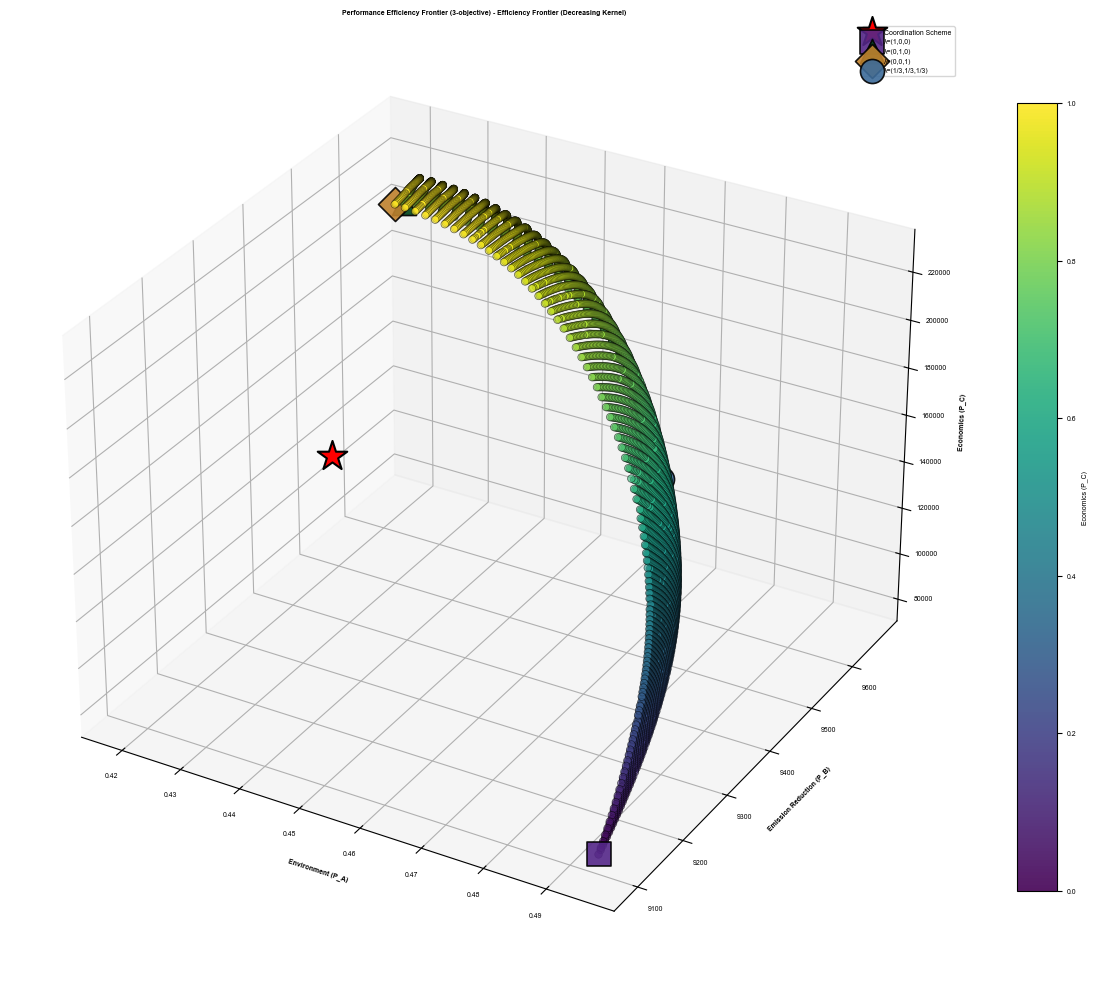

⚠️  未找到在所有维度都同时进入前10%或前20%的解
Saved to: figure/US_figure/performance_efficiency_3d_normal_with_coordination.png


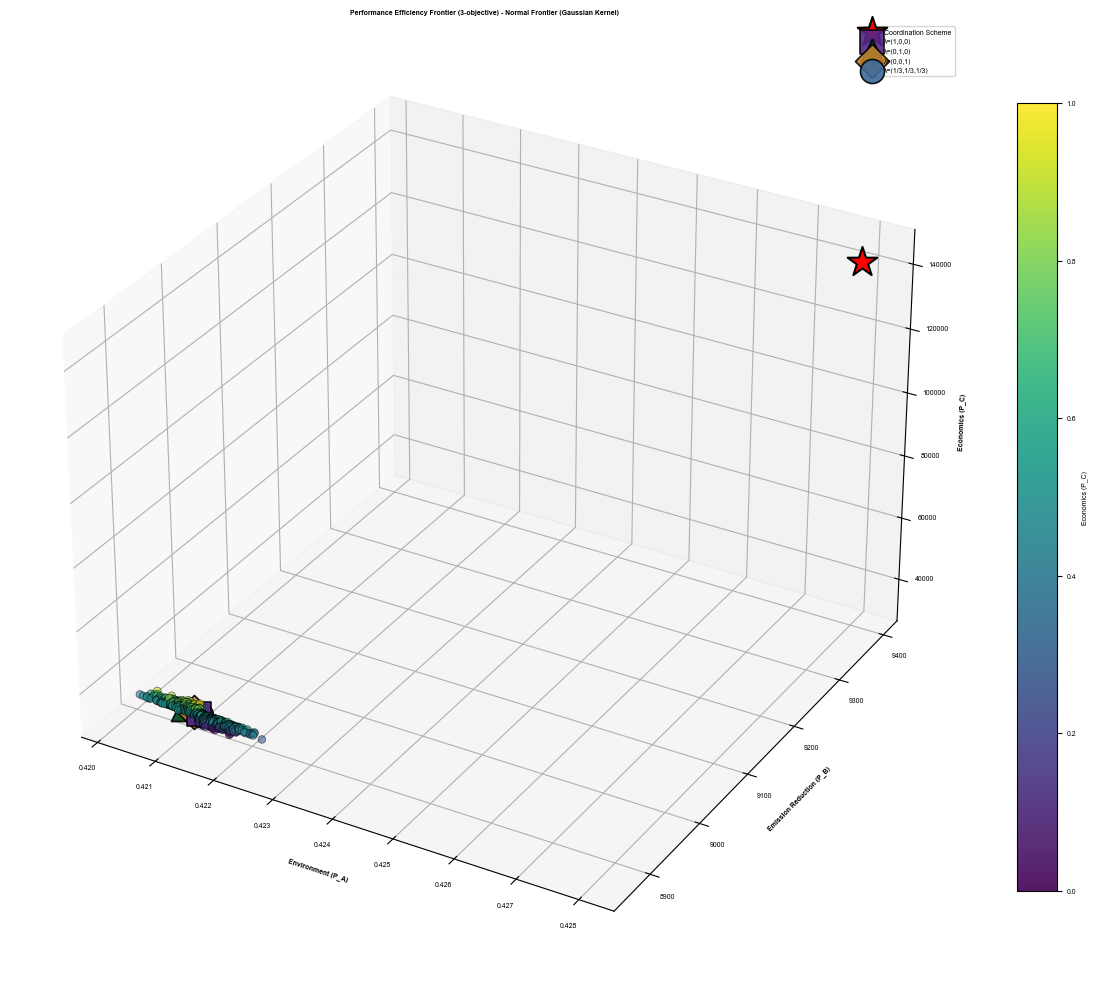

⚠️  未找到在所有维度都同时进入前10%或前20%的解
Saved to: figure/US_figure/performance_efficiency_3d_equity_with_coordination.png


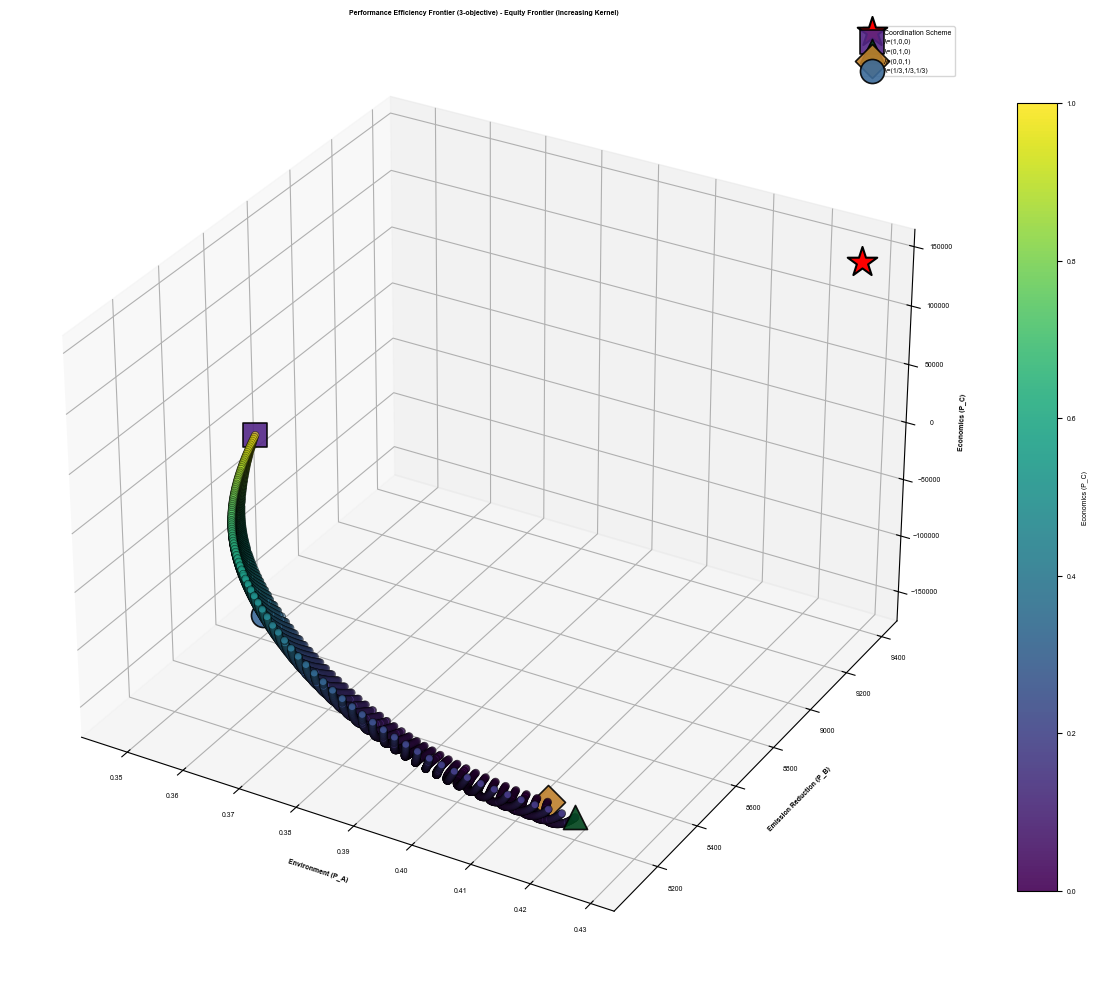

Saved comparison plot to: figure/US_figure/multi_kernel_frontiers_comparison.png


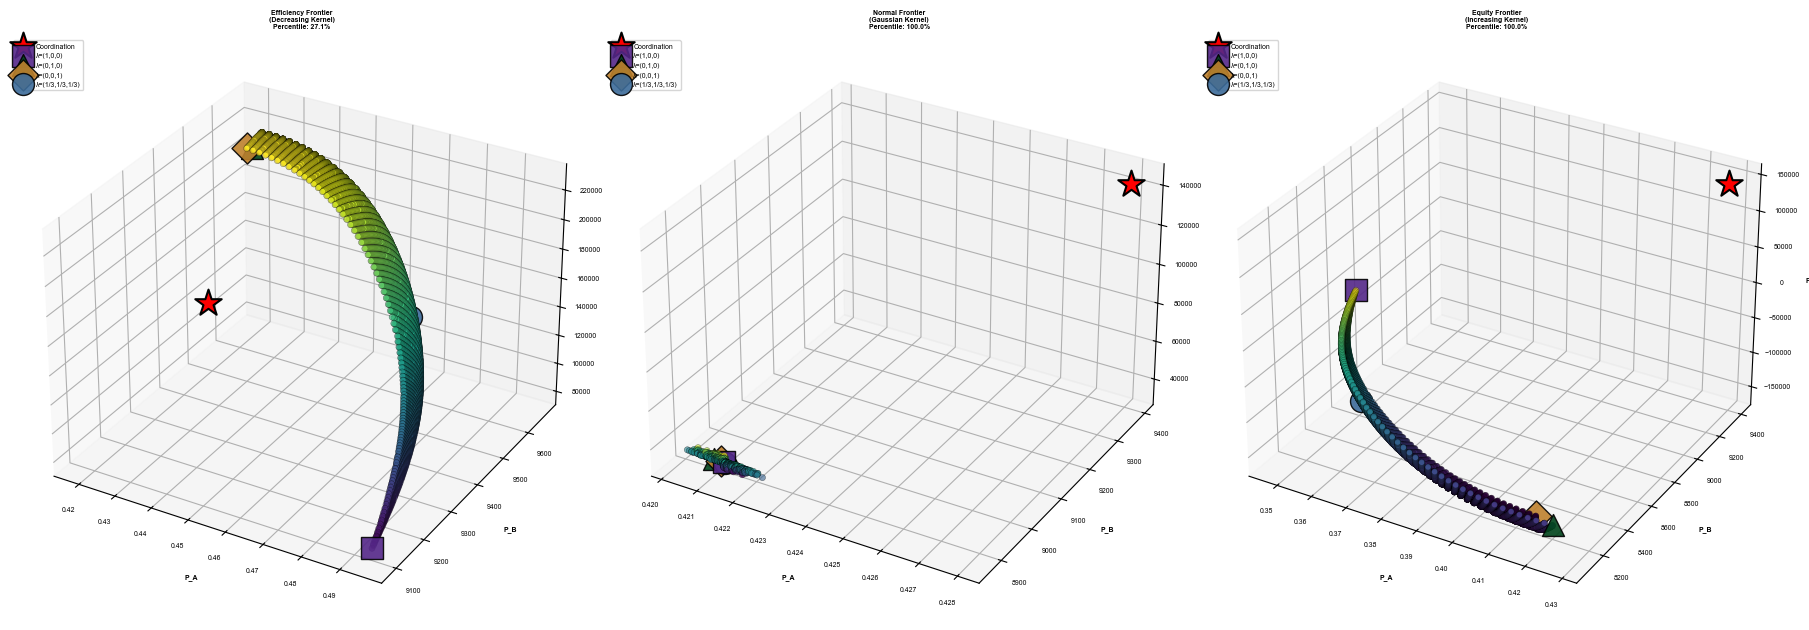


多核函数绩效前沿分析完成！


In [143]:
# 运行多核函数绩效前沿分析
multi_kernel_results = run_multi_kernel_efficiency_analysis(
    merged_data_for_analysis,
    n_candidates=5000,
    save_results=True,
    output_dir='figure/US_figure'
)

In [144]:
import pickle
with open('data/US_data/multi_kernel_results.pkl', 'wb') as f:
    pickle.dump(multi_kernel_results, f)

# 3D Plot function

In [4]:
import pickle


with open('data/US_data/multi_kernel_results.pkl', 'rb') as f:
    multi_kernel_results = pickle.load(f)



## Help function for color bar

In [123]:
import numpy as np

def hex_to_rgb01(hex_str):
    """将十六进制颜色转为 [0,1] 区间 RGB 向量"""
    hex_str = hex_str.lstrip('#')
    return np.array([int(hex_str[i:i+2], 16) for i in (0, 2, 4)], dtype=float) / 255.0


def lambda_to_rgb(lambda_array,
                  color_A_hex='#a02fff',  # A: 更鲜艳的紫色
                  color_B_hex='#009975',  # B: 宝石绿（Emerald Green）
                  color_C_hex='#d68910'   # C: 深橙色（更深的颜色）
                  ):
    """
    根据 lambda = (λ1, λ2, λ3) 线性插值颜色
    lambda_array: (N,3) 或 (3,) 的 numpy 数组
    返回: (N,3) 或 (3,) 的 RGB 数组，值域在 [0,1]
    映射出来的颜色饱和度更高
    """
    import colorsys

    lam = np.asarray(lambda_array, dtype=float)
    if lam.ndim == 1:
        lam = lam[None, :]

    # 为安全起见，对 λ 做一次截断（避免插值后出现 -0.01 或 1.01）
    lam = np.clip(lam, 0.0, 1.0)
    # 有时插值后三者和不为 1，再归一化一下
    lam_sum = lam.sum(axis=1, keepdims=True)
    lam_sum = np.where(lam_sum > 0, lam_sum, 1.0)
    lam = lam / lam_sum

    cA = hex_to_rgb01(color_A_hex)
    cB = hex_to_rgb01(color_B_hex)
    cC = hex_to_rgb01(color_C_hex)

    # 原始线性组合
    colors = lam[:, 0:1] * cA + lam[:, 1:2] * cB + lam[:, 2:3] * cC
    colors = np.clip(colors, 0.0, 1.0)

    # 增加饱和度
    def increase_saturation(rgb):
        # 转换到 HSV 增加饱和度再转回RGB
        h, l, s = colorsys.rgb_to_hls(*rgb)
        s_new = min(1.0, s * 1.35 + 0.15)  # 通过拉高s实现更高饱和度
        rgb_sat = colorsys.hls_to_rgb(h, l, s_new)
        return np.clip(rgb_sat, 0.0, 1.0)

    # 向量化
    colors_sat = np.array([increase_saturation(rgb) for rgb in colors])

    if lambda_array.ndim == 1:
        return colors_sat[0]
    return colors_sat


## 3D function

In [131]:
def plot_lambda_colored_frontiers_3d(
    multi_kernel_results=None,  
    frontiers_dict=None,         
    coordination_performance=None,
    save_path=None,
    title="Policy-aware priority frontiers in performance space",
    kernel_mode='all',  # 新增：'all' 绘制所有kernel，'single' 绘制单个kernel
    kernel_type=None,   # 新增：当 kernel_mode='single' 时指定要绘制的kernel
    show_surface=True,  # 新增：是否显示拟合曲面
    show_points=True,    # 新增：是否显示散点
    specific_lambda_results=None  # 新增：特定 lambda 组合的结果，用于标注
):

    """
    将不同核函数的 Pareto 前沿结果整合到一个 3D 空间内，使用 lambda 映射颜色，并绘制三角形 color bar
    
    参数
    ----
    multi_kernel_results : dict, optional
        run_multi_kernel_efficiency_analysis 的返回结果。
        如果提供，将自动从中提取 frontiers_dict 和 coordination_performance。
    
    frontiers_dict : dict, optional
        {kernel_type: result_dict}，其中 result_dict 至少包含:
        - 'pareto_performance_objectives': (K,3) 数组，对应 (P_A,P_B,P_C)
        - 'pareto_lambdas': (K,3) 数组，对应 (λ1,λ2,λ3)
    
    coordination_performance : array-like or None, optional
        协同方案在 (P_A,P_B,P_C) 空间中的表现效率向量，形状为 (3,)
    
    save_path : str or None
        若提供路径，则将图保存到该路径。
    
    title : str
        图标题。
    
    kernel_mode : str, default 'all'
        'all': 绘制所有kernel的前沿（合并显示）
        'single': 绘制单个kernel的前沿
    
    kernel_type : str, optional
        当 kernel_mode='single' 时，指定要绘制的kernel类型：'decreasing', 'gaussian', 或 'increasing'
    
    show_surface : bool, default True
        是否显示拟合的曲面
    
    show_points : bool, default True
        是否显示散点
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    from matplotlib.patches import Polygon
    from matplotlib.lines import Line2D
    from matplotlib.ticker import FuncFormatter
    from scipy.spatial import Delaunay
    from scipy.interpolate import griddata

    # ========== 从 multi_kernel_results 中提取数据 ==========
    if multi_kernel_results is not None:
        frontiers_dict = multi_kernel_results.get('frontiers_dict', frontiers_dict)
        coordination_performance = multi_kernel_results.get('coordination_performance', coordination_performance)
        # 如果 multi_kernel_results 中有 specific_lambda_results，且未单独提供，则使用它
        if specific_lambda_results is None:
            specific_lambda_results = multi_kernel_results.get('specific_lambda_results', None)
        
        if frontiers_dict is None:
            raise ValueError("multi_kernel_results 中未找到 'frontiers_dict'")
    
    if frontiers_dict is None:
        raise ValueError("必须提供 multi_kernel_results 或 frontiers_dict")

    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # ========== 根据 kernel_mode 选择要绘制的 kernel ==========
    if kernel_mode == 'single':
        if kernel_type is None:
            raise ValueError("当 kernel_mode='single' 时，必须指定 kernel_type")
        if kernel_type not in frontiers_dict:
            raise ValueError(f"frontiers_dict 中未找到 kernel_type: {kernel_type}")
        selected_kernels = {kernel_type: frontiers_dict[kernel_type]}
    else:  # kernel_mode == 'all'
        selected_kernels = frontiers_dict

    # -------------------------
    # 1. 收集所有 kernel 的 Pareto 点和 lambda
    # -------------------------
    P_list = []
    lambda_list = []
    kernel_tags = []
    kernel_data = {}  # 存储每个kernel的数据，用于单独绘制曲面

    for kernel_type, res in selected_kernels.items():
        # 优先使用 5000 个 λ 对应的 candidate 表现效率
        if 'candidate_performance_objectives' in res:
            P_kernel = np.asarray(res['candidate_performance_objectives'])
            lambda_kernel = np.asarray(res['lambda_grid'])
        else:
            # 回退用 Pareto
            P_kernel = np.asarray(res.get('pareto_performance_objectives'))
            lambda_kernel = np.asarray(res.get('pareto_lambdas'))
        
        if P_kernel.size == 0 or lambda_kernel.size == 0:
            continue
        
        # 确保 lambda_kernel 的形状正确
        if lambda_kernel.ndim == 1:
            lambda_kernel = lambda_kernel.reshape(-1, 3)
        if P_kernel.ndim == 1:
            P_kernel = P_kernel.reshape(-1, 3)

        P_list.append(P_kernel)
        lambda_list.append(lambda_kernel)
        kernel_tags.extend([kernel_type] * P_kernel.shape[0])
        
        # 存储每个kernel的数据
        kernel_data[kernel_type] = {
            'P': P_kernel,
            'lambda': lambda_kernel
        }

    if len(P_list) == 0:
        raise ValueError("frontiers_dict 中没有有效的 Pareto 前沿结果。")

    P_all = np.vstack(P_list)           # (N,3)
    lambda_all = np.vstack(lambda_list) # (N,3)

    # 使用 lambda 映射颜色
    point_colors = lambda_to_rgb(lambda_all)

    # -------------------------
    # 2. 绘制 3D 图
    # -------------------------
    fig = plt.figure(figsize=(3.15, 3.15))  # 80mm x 80mm in inches
    ax = fig.add_subplot(111, projection='3d')

    # ========== 设置网格样式：只保留地板网格，弱化侧面和后面 ==========
    grid_color = '#E0E0E0'
    grid_linewidth = 0.4
    
    # 启用网格
    ax.grid(True)
    
    # 设置 x 轴和 y 轴网格（地板网格）- 保留
    ax.xaxis._axinfo['grid']['linewidth'] = grid_linewidth
    ax.xaxis._axinfo['grid']['color'] = grid_color
    ax.yaxis._axinfo['grid']['linewidth'] = grid_linewidth
    ax.yaxis._axinfo['grid']['color'] = grid_color
    
    # 设置 z 轴网格 - 隐藏
    ax.zaxis._axinfo['grid']['linewidth'] = grid_linewidth
    ax.zaxis._axinfo['grid']['color'] = grid_color
    
    # 隐藏所有坐标平面填充，只保留网格线
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    


    # 绘制散点
    if show_points:
        sc = ax.scatter(
            P_all[:, 0], P_all[:, 1], P_all[:, 2],
            c=point_colors,
            s=0.5,
            alpha=0.85,
            edgecolors=None,
            linewidths=0.3,
            label='Pareto Frontier'
        )
            # -------------------------
    # 3. 用规则小网格 + 全局二次曲面回归绘制平滑曲面
    # -------------------------
    if show_surface:
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression
        from scipy.spatial import Delaunay

        # 三次曲面：z = b0 + b1*x + b2*y + b3*x^2 + b4*x*y + b5*y^2 + b6*x^3 + b7*x^2*y + b8*x*y^2 + b9*y^3
        poly = PolynomialFeatures(degree=3, include_bias=False)

        for ktype, data in kernel_data.items():
            P_kernel = data['P']        # (N,3) -> (P_A, P_B, P_C)
            lam_kernel = data['lambda'] # (N,3) -> (λ1, λ2, λ3)

            n_points = P_kernel.shape[0]
            if n_points < 10:
                continue

            x = P_kernel[:, 0]
            y = P_kernel[:, 1]
            z = P_kernel[:, 2]

            # ①（可选）下采样，防止点太多拟合过慢
            max_points = 4000
            if n_points > max_points:
                rng = np.random.default_rng(42)
                idx = rng.choice(n_points, size=max_points, replace=False)
                x = x[idx]
                y = y[idx]
                z = z[idx]
                lam_kernel = lam_kernel[idx]
                n_points = max_points

            # ② 设计矩阵：多项式特征
            XY = np.column_stack([x, y])         # (N,2)
            X_poly = poly.fit_transform(XY)      # (N,6) 对应 x,y,x²,xy,y²,...

            # ③ 拟合 P_C 的全局二次曲面
            model_z = LinearRegression().fit(X_poly, z)

            # ④ 分别拟合 λ1, λ2, λ3 的全局二次曲面
            model_l1 = LinearRegression().fit(X_poly, lam_kernel[:, 0])
            model_l2 = LinearRegression().fit(X_poly, lam_kernel[:, 1])
            model_l3 = LinearRegression().fit(X_poly, lam_kernel[:, 2])

            # ⑤ 在 P_A–P_B 平面上构建规则网格
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()

            grid_res = 200  
            xi = np.linspace(x_min, x_max, grid_res)
            yi = np.linspace(y_min, y_max, grid_res)
            Xi, Yi = np.meshgrid(xi, yi)

            # ⑥ 对网格做同样的多项式特征，并预测 Z 与 λ
            XY_grid = np.column_stack([Xi.ravel(), Yi.ravel()])   # (R*R,2)
            Xg_poly = poly.transform(XY_grid)                      # (R*R,6)

            Z_pred = model_z.predict(Xg_poly).reshape(Xi.shape)          # P_C
            lam1_pred = model_l1.predict(Xg_poly).reshape(Xi.shape)
            lam2_pred = model_l2.predict(Xg_poly).reshape(Xi.shape)
            lam3_pred = model_l3.predict(Xg_poly).reshape(Xi.shape)

            # ⑦ 归一化 λ，防止略微越界
            lam_sum = lam1_pred + lam2_pred + lam3_pred
            lam_sum = np.where(lam_sum > 0, lam_sum, 1.0)
            lam1_pred /= lam_sum
            lam2_pred /= lam_sum
            lam3_pred /= lam_sum

            # ⑧ 只在 (P_A,P_B) 的凸包内部显示曲面，外部设为透明
            hull = Delaunay(np.column_stack([x, y]))
            grid_points = np.column_stack([Xi.ravel(), Yi.ravel()])
            inside = hull.find_simplex(grid_points) >= 0
            inside_mask = inside.reshape(Z_pred.shape)

            # ⑨ 生成颜色网格 (grid_res, grid_res, 4)
            lam_stack = np.stack([lam1_pred, lam2_pred, lam3_pred], axis=-1)  # (R,R,3)

            # 可选：把 λ 往 (1/3,1/3,1/3) 收缩一点，颜色过渡更柔和（为了更鲜艳，这里减小收缩系数或直接不用收缩）
            # shrink = 0.8
            # lam_stack = shrink * lam_stack + (1 - shrink) * (1.0 / 3.0)

            # 饱和度更高一点：加大color权重、不过度靠近中心
            shrink_sat = 0.97  # 1.0为最大饱和，0更柔和/灰
            lam_stack = shrink_sat * lam_stack + (1 - shrink_sat) * (1.0 / 3.0)

            lam_flat = lam_stack.reshape(-1, 3)
            rgb_flat = lambda_to_rgb(lam_flat)                                  # (R*R,3)

            # 可微微提高alpha让颜色显得更亮
            alpha_val = 1
            rgba_flat = np.concatenate(
                [rgb_flat, np.full((rgb_flat.shape[0], 1), alpha_val)],
                axis=1
            )
            colors_grid = rgba_flat.reshape(grid_res, grid_res, 4)

            # 凸包外：全透明
            colors_grid[~inside_mask] = [0, 0, 0, 0]
            colors_grid = np.clip(colors_grid, 0.0, 1.0).astype(np.float32)

            # ⑩ 绘制整体光滑的效率前沿曲面
            surf = ax.plot_surface(
                Xi, Yi, Z_pred,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=True,
                shade=False,
                facecolors=colors_grid
            )

    # -------- 先计算轴范围，用于格式化器 --------
    x_min, x_max = P_all[:, 0].min(), P_all[:, 0].max()
    y_min, y_max = P_all[:, 1].min(), P_all[:, 1].max()
    z_min, z_max = P_all[:, 2].min(), P_all[:, 2].max()

    # 设置坐标轴标签和格式化器
    # A: Environmental (Unitless)
    ax.set_xlabel('Environmental\n(Unitless)', fontweight='bold', labelpad=-6)  # 缩短label与轴的距离（默认为6-8，加小labelpad）

    # B: Emission (kt CO$_2$ ha$^{-1}$) - 需要除以1e3显示
    # 保留一位小数
    ax.set_ylabel('Emission\n(kt CO$_2$ ha$^{-1}$)', fontweight='bold', labelpad=-6)  # labelpad也调低一点
    def format_y_emission(x, pos):
        return f'{x/1e3:.2f}'
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_emission))

    # 刻度更稀疏一点（减少显示的刻度数量）
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))
    ax.zaxis.set_major_locator(MaxNLocator(nbins=5, prune=None))

    # 让y轴刻度数字更靠近轴
    ax.tick_params(axis='x', pad=-4)  
    ax.tick_params(axis='y', pad=-4)  
    ax.tick_params(axis='z', pad=-4)  

    # C: Economic (kUSD ha$^{-1}$)
    # 根据数值范围自动调整精度
    z_range = z_max - z_min
    if z_range > 100000:
        z_precision = 0
    elif z_range > 10000:
        z_precision = 1
    else:
        z_precision = 2
    ax.set_zlabel('Economic\n(kUSD ha$^{-1}$)', fontweight='bold', labelpad=-9)
    def format_z_economic(x, pos):
        return f'{x/1e3:.{z_precision}f}'
    ax.zaxis.set_major_formatter(FuncFormatter(format_z_economic))



    # -------- 视角与轴范围优化 --------
    # 让三个轴都稍微留一点 margin，避免"贴边"

    def _add_margin(vmin, vmax, ratio=0.08):
        rng = vmax - vmin
        if rng == 0:
            rng = max(abs(vmin), 1.0)
        pad = rng * ratio
        return vmin - pad, vmax + pad

    ax.set_xlim(*_add_margin(x_min, x_max))
    ax.set_ylim(*_add_margin(y_min, y_max))
    ax.set_zlim(*_add_margin(z_min, z_max))

    # 设置视角：
    # - elev 较低一点，让曲面的"弧度"更清晰
    # - azim 侧一点，让 P_A–P_C 的弯曲能被看到
    if kernel_mode == 'single':
        if kernel_type == 'decreasing':
            elev, azim = 27, 55    # 效率核：从侧前方看
        elif kernel_type == 'gaussian':
            elev, azim = 25, 45     # 高斯核：更侧一点
        elif kernel_type == 'increasing':
            elev, azim = 25, 135    # 公平核：从另一侧看
        else:
            elev, azim = 22, -60
    else:
        # 多 kernel 合并时，用一个比较中性的视角
        elev, azim = 20, -120

    ax.view_init(elev=elev, azim=azim)
    # 拉远一点，避免近距离透视变形太强
    ax.dist = 8

    # -------------------------
    # 4. 标出协同方案 (3E-Synergy solution)
    # -------------------------
    legend_handles = []
    legend_labels = []

    if coordination_performance is not None:
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, for some matplotlib versions
        import matplotlib.colors as mcolors

        coord = np.asarray(coordination_performance, dtype=float).ravel()
        # 绘制一个立体的球体，而不是单纯的点
        # 球体参数
        sphere_radius = 0.032 * (ax.get_xlim()[1] - ax.get_xlim()[0])  # 根据坐标轴动态设置半径

        # 生成球体表面点
        u = np.linspace(0, 2 * np.pi, 32)
        v = np.linspace(0, np.pi, 32)
        xs = coord[0] + sphere_radius * np.outer(np.cos(u), np.sin(v))
        ys = coord[1] + sphere_radius * np.outer(np.sin(u), np.sin(v))
        zs = coord[2] + sphere_radius * np.outer(np.ones_like(u), np.cos(v))

        # 使用 Poly3DCollection 绘制立体球体（有光泽感）
        # 可选：实现类似材质感/高光
        face_color = mcolors.to_rgba('red', alpha=0.92)
        sphere = ax.plot_surface(
            xs, ys, zs, rstride=1, cstride=1,
            color=face_color,
            linewidth=0, antialiased=True, shade=True, zorder=12,
            alpha=0.92
        )
        # 添加一个略粗黑色边线的圆心点以强调中心
        center_dot = ax.scatter(
            coord[0], coord[1], coord[2],
            marker='o', s=10, c='red',
            edgecolors=None, linewidths=1.3, zorder=11
        )
        legend_handles.append(center_dot)
        legend_labels.append('Coordination Scheme')
    # -------------------------
    # 4.5. 标注特殊 lambda 组合并连接到协同方案
    # -------------------------
    if specific_lambda_results is not None and coordination_performance is not None:
        # 定义不同 lambda 组合的颜色和标记，全部用圆形
        lambda_markers = {
            '(1,0,0)': {'marker': 'o', 'color': '#542788', 'label': 'λ=(1,0,0)', 'size': 20},  # 紫色圆点
            '(0,1,0)': {'marker': 'o', 'color': '#00441b', 'label': 'λ=(0,1,0)', 'size': 20},  # 绿色圆点
            '(0,0,1)': {'marker': 'o', 'color': '#bf812d', 'label': 'λ=(0,0,1)', 'size': 20},  # 棕色圆点
        }
        
        coord = np.asarray(coordination_performance, dtype=float).ravel()
        
        # 遍历所有 kernel 的特殊 lambda 结果，或者使用第一个 kernel 的结果
        # 如果 specific_lambda_results 是嵌套字典（按 kernel 分类），取第一个 kernel 的结果
        if isinstance(specific_lambda_results, dict):
            # 检查是否是嵌套结构 {kernel_type: {lambda_name: {...}}}
            first_key = list(specific_lambda_results.keys())[0]
            if isinstance(specific_lambda_results[first_key], dict) and 'performance_efficiency' not in specific_lambda_results[first_key]:
                # 是嵌套结构，取第一个 kernel 的结果
                kernel_specific = specific_lambda_results[first_key]
            else:
                # 直接是 {lambda_name: {...}} 结构
                kernel_specific = specific_lambda_results
        
        # 只标注三个特殊的 lambda 组合
        target_lambda_names = ['(1,0,0)', '(0,1,0)', '(0,0,1)']
        for lambda_name in target_lambda_names:
            if lambda_name in kernel_specific:
                res = kernel_specific[lambda_name]
                if 'performance_efficiency' in res:
                    perf = np.asarray(res['performance_efficiency'])
                    marker_info = lambda_markers.get(lambda_name, {'marker': 'o', 'color': 'gray', 'label': lambda_name, 'size': 80})
                    
                    # 绘制特殊 lambda 组合的点
                    scatter = ax.scatter(
                        perf[0], perf[1], perf[2],
                        c=marker_info['color'],
                        marker=marker_info['marker'],
                        s=marker_info['size'],
                        edgecolors=None,
                        linewidths=1,
                        alpha=0.95,
                        zorder=13,
                        label=marker_info['label']
                    )
                    legend_handles.append(scatter)
                    legend_labels.append(marker_info['label'])
                    
                    # 用虚线从协同方案连接到特殊 lambda 组合的点
                    ax.plot(
                        [coord[0], perf[0]],
                        [coord[1], perf[1]],
                        [coord[2], perf[2]],
                        linestyle='--',
                        linewidth=0.8,
                        color=marker_info['color'],
                        alpha=0.6,
                        zorder=10
                    )
    # -------------------------
    # 5. 三角形 lambda colour map（严格正三角形 + 光滑色块）
    # -------------------------
    ax_inset = inset_axes(ax, width="15%", height="15%",
                          loc='upper left', borderpad=0)  # 取消边框

    # 等边三角形顶点（数据坐标）
    h = np.sqrt(3) / 2.0
    B = np.array([0.0, 0.0])      # λ_B = 1
    C = np.array([1.0, 0.0])      # λ_C = 1
    A_pt = np.array([0.5, h])     # λ_A = 1

    # 图像分辨率：越大越平滑
    img_res = 400
    H, W = img_res, img_res
    img = np.zeros((H, W, 4), dtype=float)  # RGBA

    # 预先算好用于 barycentric 的常数
    v0, v1, v2 = B, C, A_pt
    denom = ((v1[1] - v2[1]) * (v0[0] - v2[0]) +
             (v2[0] - v1[0]) * (v0[1] - v2[1]))

    for iy in range(H):
        # y 坐标：0 ~ h
        y = (iy + 0.5) / H * h
        for ix in range(W):
            # x 坐标：0 ~ 1
            x = (ix + 0.5) / W
            p = np.array([x, y])

            # 计算相对于三个顶点的 barycentric
            # 这里 lB, lC, lA 是以 (B,C,A) 为顺序的权重
            lB = ((v1[1] - v2[1]) * (p[0] - v2[0]) +
                  (v2[0] - v1[0]) * (p[1] - v2[1])) / denom
            lC = ((v2[1] - v0[1]) * (p[0] - v2[0]) +
                  (v0[0] - v2[0]) * (p[1] - v2[1])) / denom
            lA = 1.0 - lB - lC

            # 在三角形外：跳过，保持透明
            if (lA < 0) or (lB < 0) or (lC < 0):
                continue

            # 这里约定 λ_A = lA, λ_B = lB, λ_C = lC
            lam = np.array([lA, lB, lC], dtype=float)

            rgb = lambda_to_rgb(lam)
            img[iy, ix, 0:3] = rgb
            img[iy, ix, 3] = 1.0  # alpha

    # 显示图像：坐标范围正好是等边三角形的包围盒
    extent = (0.0, 1.0, 0.0, h)
    ax_inset.imshow(img,
                    origin='lower',
                    extent=extent,
                    interpolation='bilinear')

    # 取消边框线
    for spine in ax_inset.spines.values():
        spine.set_visible(False)

    ax_inset.set_aspect('equal')
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_xlim(-0.05, 1.05)
    ax_inset.set_ylim(-0.05, h + 0.05)

    ax_inset.text(A_pt[0], A_pt[1] + 0.03, 'Environmental', ha='center', va='bottom',
                  fontsize=5, color='black')
    ax_inset.text(B[0] - 0.00, B[1] - 0.02, 'Emission', ha='right', va='top',
                  fontsize=5, color='black')
    ax_inset.text(C[0] + 0.00, C[1] - 0.02, 'Economic', ha='left', va='top',
                  fontsize=5, color='black')





    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved 3D lambda-coloured frontier plot to: {save_path}")

    plt.show()
    return fig

Saved 3D lambda-coloured frontier plot to: figure/US_figure/lambda_coloured_frontiers_3d_decreasing.png


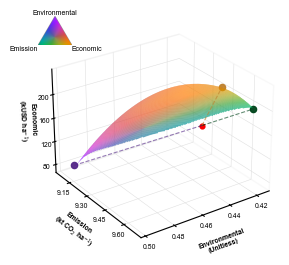

Saved 3D lambda-coloured frontier plot to: figure/US_figure/lambda_coloured_frontiers_3d_all.png


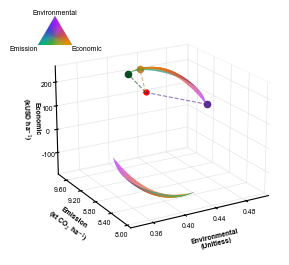

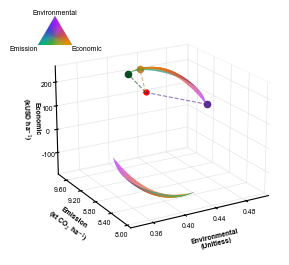

In [132]:
plot_lambda_colored_frontiers_3d(
    multi_kernel_results=multi_kernel_results,
    save_path='figure/US_figure/lambda_coloured_frontiers_3d_decreasing.png',
    kernel_mode='single',
    kernel_type='decreasing',
    show_surface=True,
    show_points=False
)


# 方式1：绘制所有kernel（带曲面）
plot_lambda_colored_frontiers_3d(
    multi_kernel_results=multi_kernel_results,
    save_path='figure/US_figure/lambda_coloured_frontiers_3d_all.png',
    kernel_mode='all',
    show_surface=True,
    show_points=False
)